# Data exploration

In [1]:
import os
# cuda_visible_devices = 0,1,2,3
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

import pandas as pd

import numpy as np
from tabulate import tabulate
import seaborn as sns
from tqdm import tqdm

import nltk
from nltk import WordPunctTokenizer
from nltk import TreebankWordTokenizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords

import stanza
stanza.download('en')

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel

import torch

RANDOM_SEED = 42

[nltk_data] Downloading package punkt to /home/alocaputo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/alocaputo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alocaputo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alocaputo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/data01/alocaputo/miniconda3/envs/icdar2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-04 13:22:35 INFO: Downloaded file to /home/alocaputo/stanza_resources/resources.json
2025-03-04 13:22:35 INFO: Downloading default packages for language: en (Engl

## Load Data

In [2]:
texts_path = './data/Task2/texts'

train_path = os.path.join(texts_path, 'train')
valid_path = os.path.join(texts_path, 'valid')

train_files = os.listdir(train_path)
valid_files = os.listdir(valid_path)

f"Train: {len(train_files)}, Test: {len(valid_files)}"

label2century = {1: '17th century', 2: '18th century', 3: '19th century', 4: '20th century', 5: '21st century'}

train21 = pd.read_csv('./data/Task2/task2.1/train.csv')
valid21 = pd.read_csv('./data/Task2/task2.1/valid.csv')

train22 = pd.read_csv('./data/Task2/task2.2/train.csv')
valid22 = pd.read_csv('./data/Task2/task2.2/valid.csv')

train = pd.merge(train21, train22, on='id')
train.rename(columns={'label_x': 'century', 'label_y': 'decade'}, inplace=True)
train['file_name'] = train['id']
train['id'] = train.id.str.replace('train_text', '').str.replace('.txt', '').astype(int)
train.set_index('id', inplace=True)

valid = pd.merge(valid21, valid22, on='id')
valid.rename(columns={'label_x': 'century', 'label_y': 'decade'}, inplace=True)
valid['file_name'] = valid['id']
valid['id'] = valid.id.str.replace('valid_text', '').str.replace('.txt', '').astype(int)
valid.set_index('id', inplace=True)

In [3]:
train21_count = train21.groupby('id').count()
print(len(train21), len(train21_count[train21_count['label'] > 1]))
train21_count[train21_count['label'] > 1].head()

204708 0


,label
id,


In [4]:
train22_count = train22.groupby('id').count()
print(len(train22), len(train22_count[train22_count['label'] > 1]))
train22_count[train22_count['label'] > 1].head()

204708 0


,label
id,


In [5]:
# check if the ids are the same
train21_ids = set(train21_count[train21_count['label'] > 1].index.tolist())
train22_ids = set(train22_count[train22_count['label'] > 1].index.tolist())

print(train21_ids == train22_ids)

blacklist = train21_ids

True


In [6]:
# check if the ids are the same
valid21_count = valid21.groupby('id').count()
valid22_count = valid22.groupby('id').count()
valid21_ids = set(valid21_count[valid21_count['label'] > 1].index.tolist())
valid22_ids = set(valid22_count[valid22_count['label'] > 1].index.tolist())

print(valid21_ids == valid22_ids)

blacklist = valid21_ids

True


Text sample

In [7]:
with open(os.path.join(train_path, train_files[42]), 'r') as file:
    a = file.read()
    print(a)
    print("len:", len(a))

endorsed the names of Mr. and Mrs. H.G. Stone and the single passenger claimed the title of Robert Edgerly. The seats had been assigned by the steward with written cards on each plate, and Mr. Edgerly, who sat at my left, took up that of Miss Carney. "We have still another messmate, who has not made her appearance," he said, to the table in general. "Miss M. Carney." "The lady is not feeling well and will not appear to-night," I said. "I believe she occupies the stateroom with me," said Miss Howes, to my surprise. "She is evidently not used to the sea, for she was taken ill before the steamer left the dock." "Miss Carney is my cousin," I explained, forced into it by the inquiring eyes of Mr. Howes, who evidently connected us in some way. "She was not very well before we started, is in fact taking the journey mainly for her health. I hope she will feel able to be out to-morrow." With the freedom that sometimes prevails in parties thrown together at a steamer table the conversation then 

## Texts Summaries

Average length (characters)

In [8]:
train_texts_legths = np.array([ len(open(os.path.join(train_path, file_name), 'r').read()) for file_name in train_files])
valid_texts_legths = np.array([ len(open(os.path.join(valid_path, file_name), 'r').read()) for file_name in valid_files])

all_texts_lengths = np.append(train_texts_legths, valid_texts_legths)

tabulate([['Train', train_texts_legths.min(), train_texts_legths.max(), train_texts_legths.mean(), train_texts_legths.std()],
            ['Valid', valid_texts_legths.min(), valid_texts_legths.max(), valid_texts_legths.mean(), valid_texts_legths.std()],
            ['All', all_texts_lengths.min(), all_texts_lengths.max(), all_texts_lengths.mean(), all_texts_lengths.std()]],
            headers=['Dataset', 'Min', 'Max', 'Mean', 'Std'],
            tablefmt='html')

Dataset,Min,Max,Mean,Std
Train,4,12182,5555.98,451.691
Valid,5,10731,5555.16,450.727
All,4,12182,5555.81,451.489


/tmp/ipykernel_45574/2417307357.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([all_texts_lengths, valid_texts_legths, train_texts_legths ], labels=['All', 'Valid', 'Train'], vert=False)


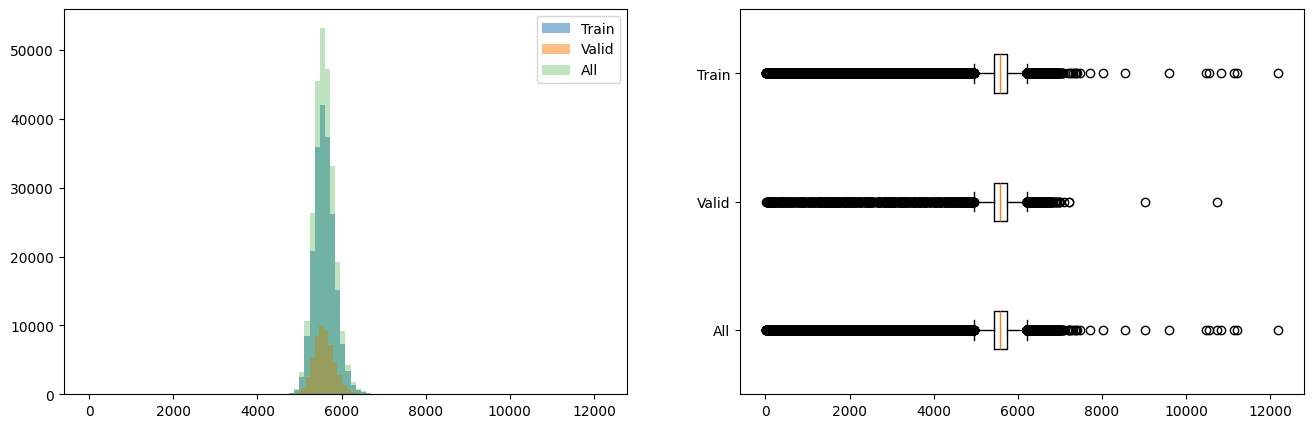

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].hist(train_texts_legths, bins=100, alpha=0.5, label='Train')
axs[0].hist(valid_texts_legths, bins=100, alpha=0.5, label='Valid')
axs[0].hist(all_texts_lengths, bins=100, alpha=0.3, label='All')
axs[0].legend(loc='upper right')


axs[1].boxplot([all_texts_lengths, valid_texts_legths, train_texts_legths ], labels=['All', 'Valid', 'Train'], vert=False)

fig.show()

Average length (words)

In [10]:
train_word_counts = np.array([ len(open(os.path.join(train_path, file_name), 'r').read().split()) for file_name in train_files])
valid_word_counts = np.array([ len(open(os.path.join(valid_path, file_name), 'r').read().split()) for file_name in valid_files])
all_word_counts = np.append(train_word_counts, valid_word_counts)

tabulate([['Train', train_word_counts.min(), train_word_counts.max(), train_word_counts.mean(), train_word_counts.std()],
            ['Valid', valid_word_counts.min(), valid_word_counts.max(), valid_word_counts.mean(), valid_word_counts.std()],
            ['All', all_word_counts.min(), all_word_counts.max(), all_word_counts.mean(), all_word_counts.std()]],
            headers=['Dataset', 'Min', 'Max', 'Mean', 'Std'],
            tablefmt='html')

Dataset,Min,Max,Mean,Std
Train,1,1020,992.735,69.2659
Valid,1,1018,992.755,69.0634
All,1,1020,992.739,69.2233


/tmp/ipykernel_45574/3462081965.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([all_word_counts, valid_word_counts, train_word_counts ], labels=['All', 'Valid', 'Train'], vert=False)


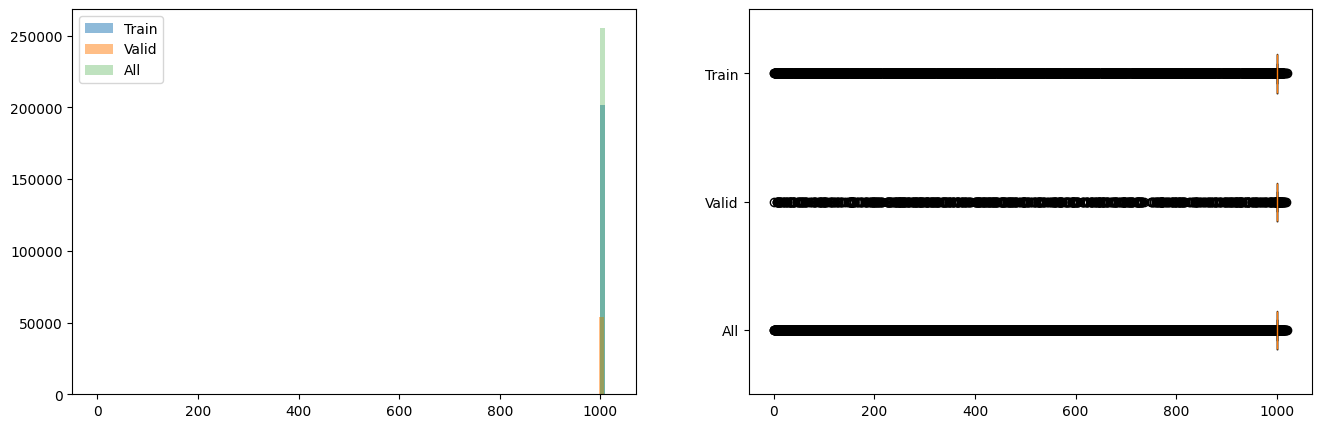

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].hist(train_word_counts, bins=100, alpha=0.5, label='Train')
axs[0].hist(valid_word_counts, bins=100, alpha=0.5, label='Valid')
axs[0].hist(all_word_counts, bins=100, alpha=0.3, label='All')
axs[0].legend(loc='upper left')

axs[1].boxplot([all_word_counts, valid_word_counts, train_word_counts ], labels=['All', 'Valid', 'Train'], vert=False)
plt.show()

## Dataset Analysis

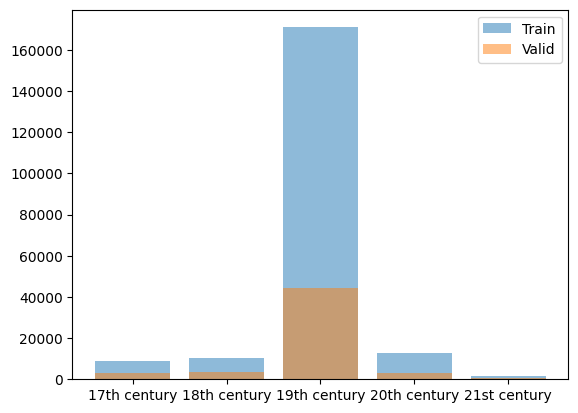

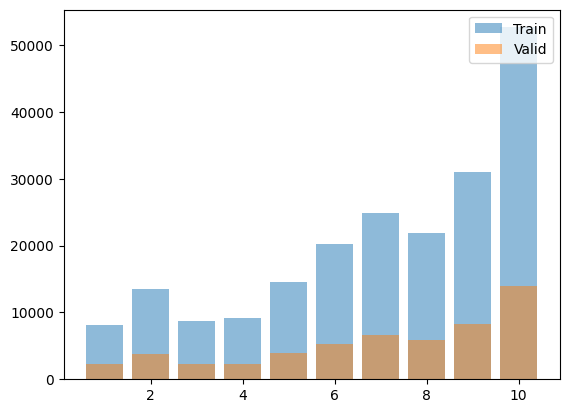

In [12]:
train21_labels_count = train21.groupby('label').count()
valid21_labels_count = valid21.groupby('label').count()

plt.bar(label2century.values(), train21_labels_count.to_dict()['id'].values(), alpha=0.5, label='Train')
plt.bar(label2century.values(), valid21_labels_count.to_dict()['id'].values(), alpha=0.5, label='Valid')
plt.legend(loc='upper right')
plt.show()

train22_labels_count = train22.groupby('label').count()
valid22_labels_count = valid22.groupby('label').count()

plt.bar(train22_labels_count.to_dict()['id'].keys(), train22_labels_count.to_dict()['id'].values(), alpha=0.5, label='Train')
plt.bar(valid22_labels_count.to_dict()['id'].keys(), valid22_labels_count.to_dict()['id'].values(), alpha=0.5, label='Valid')
plt.legend(loc='upper right')
plt.show()

In [13]:
df = train.groupby(['century', 'decade']).count()
df = df.reset_index()
df.century = df.century.map(label2century)

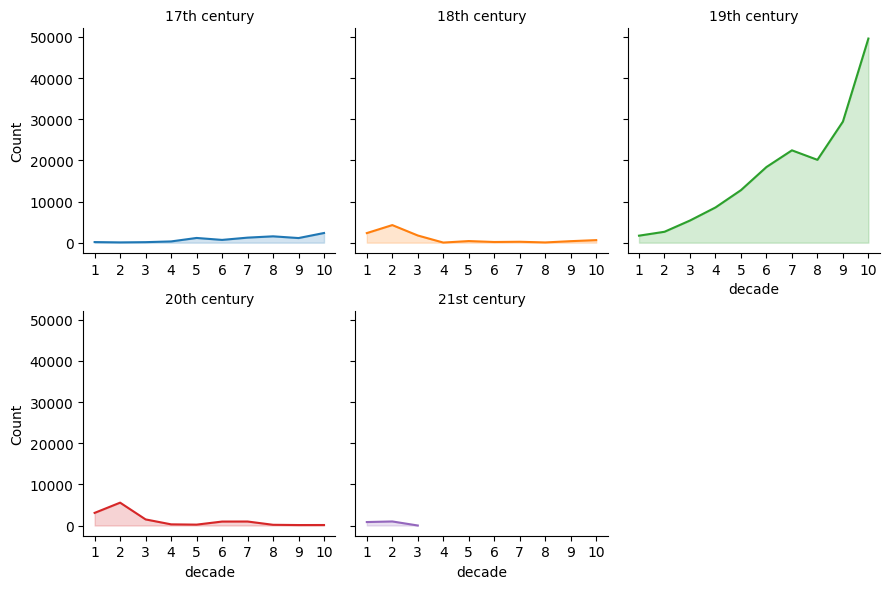

In [14]:
g = sns.FacetGrid(df, col='century', hue='century', col_wrap=3, )

g = g.map(plt.plot, 'decade', 'file_name')
g = g.map(plt.fill_between, 'decade', 'file_name', alpha=0.2)
g = g.set_titles("{col_name}")
g.tick_params(axis='x', labelbottom=True)
g.set(xticks=range(1,11))
g.set_ylabels('Count')
plt.show()



Vocabulary per century

In [15]:
text_by_century = {century: [] for century in label2century.values()}
for i, row in tqdm(train21.iterrows(), total=len(train21)):
    with open(os.path.join(train_path, row['id']), 'r', encoding='utf-8') as file:
        text_by_century[label2century[row['label']]].append(file.read())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204708/204708 [00:13<00:00, 15077.06it/s]


In [16]:
split_on_space = text_by_century['17th century'][0].split()

In [17]:
split_nltk_word = nltk.word_tokenize(text_by_century['17th century'][0], language='english')
split_nlkt_word_punct = WordPunctTokenizer().tokenize(text_by_century['17th century'][0])
split_nltk_treebank = TreebankWordTokenizer().tokenize(text_by_century['17th century'][0])

In [18]:
nlp = stanza.Pipeline(lang='en', processors='tokenize', tokenize_no_ssplit=True)
document = nlp(text_by_century['17th century'][0])

split_stanza = [ token.text for sentence in document.sentences for token in sentence.tokens ]

2025-03-04 13:23:13 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-03-04 13:23:13 INFO: Downloaded file to /home/alocaputo/stanza_resources/resources.json
2025-03-04 13:23:13 WARNING: Language en package default expects mwt, which has been added
2025-03-04 13:23:13 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |

2025-03-04 13:23:15 INFO: Using device: cuda
2025-03-04 13:23:15 INFO: Loading: tokenize
2025-03-04 13:23:17 INFO: Loading: mwt
2025-03-04 13:23:17 INFO: Done loading processors!


In [19]:
print(len(split_on_space), len(split_nltk_word), len(split_nlkt_word_punct), len(split_nltk_treebank), len(split_stanza))

1000 1214 1880 1151 1293


In [20]:
def has_strange_chars(text):
    for char in text:
        if ord(char) > 127:
            return True
    return False

def remove_strange_chars(text):
    return ''.join([char for char in text if ord(char) < 127])

def keep_strange_chars(text):
    return ''.join([char if char != u"\u009C" else ' ' for char in text if ord(char) > 127])

strange_chars_set = set()
for word in split_on_space:
    if has_strange_chars(word):
        strange_chars = keep_strange_chars(word).strip()
        # print(word, "|", strange_chars)
        for sc in strange_chars.split(' '):
            strange_chars_set.add(sc)

strange_chars_set

{'Ã¢Â\x80Â', 'Ã¢Â\x80Â\x99', 'Ã¢Â\x80Â\x99Ã¢Â\x80Â'}

In [21]:
'Ã¢Â\x80Â' in text_by_century['17th century'][0]

True

In [22]:
text_by_century['20th century'][:15]

['coupons which fall due on the fifteenth; to pay them into my bank a week in advance, in accordance with my custom. What do I find? I find the safe locked and apparently intact, as when I last saw it a month ago. But it is far from being intact, sir! It has been opened, ransacked, cleared out! Not a single bond, not a scrap of paper remains." It was obvious that the manager\'s temperature had been rising during the latter part of this speech and now he boiled over. "Pardon my flatly contradicting you, Professor Bulge. You have again referred to your visit here a month ago as your last. You will bear witness of that, gentlemen. When I inform you that the professor had access to his safe as recently as on Monday last you will recognize the importance that the statement may assume." The professor glared across the room like an infuriated animal, a comparison heightened by his notoriously hircine appearance. "How dare you contradict me, sir!" he cried, slapping the table sharply with his 

Questions:

- Encoding problems Ã¢ÂÂ in 17th, check if presnet also in others -> fix_text
- More instances of the same book? Check Montecristo's names
- What if are modern translations?

## Baseline (Task 2.1)

In [24]:
np.random.seed(RANDOM_SEED)

X_train = []
y_train = []
for i in range(1, 6):
    x = train21[train21['label'] == i].sample(1834)
    X_train.extend(x['id'])
    y_train.extend(x['label'])

X_valid_full = valid21['id']
y_valid_full = valid21['label']

X_valid = []
y_valid = []
for i in range(1, 6):
    x = valid21[valid21['label'] == i].sample(457)
    X_valid.extend(x['id'])
    y_valid.extend(x['label'])

y_train = [x-1 for x in y_train]
y_valid = [x-1 for x in y_valid]
y_valid_full = [x-1 for x in y_valid_full]

In [51]:
import sklearn
def evaluate_model(pipe, X_valid, y_valid, valid_path):
    from sklearn.metrics import classification_report

    print(classification_report(y_valid, pipe.predict([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid])))

def print_confusion_matrix(y_valid, y_pred):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    label2century = {0: '17th century', 1: '18th century', 2: '19th century', 3: '20th century', 4: '21st century'}
    cm = confusion_matrix(y_valid, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label2century.values(), yticklabels=label2century.values())
    plt.show()

In [50]:
def mean_avg_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

### Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 192 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of 100 | elapsed:    0.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 out of 100 | elapsed:    0.0s remaining:    1.5s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:    0.1s finished


============================== Valid (Partial) ==============================


[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 out of 100 | elapsed:    0.0s remaining:    1.6s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           0       0.38      0.40      0.39       457
           1       0.36      0.27      0.30       457
           2       0.38      0.36      0.37       457
           3       0.48      0.67      0.56       457
           4       0.82      0.67      0.74       457

    accuracy                           0.48      2285
   macro avg       0.48      0.48      0.47      2285
weighted avg       0.48      0.48      0.47      2285



[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 out of 100 | elapsed:    0.0s remaining:    1.6s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:    0.1s finished


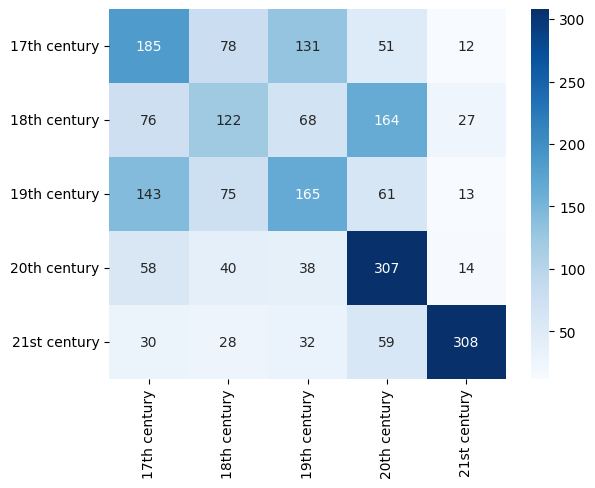

============================== Valid (Full) ==============================


[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 out of 100 | elapsed:    0.2s remaining:    8.8s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:    0.3s finished


              precision    recall  f1-score   support

           0       0.07      0.40      0.13      3077
           1       0.08      0.25      0.12      3340
           2       0.89      0.31      0.46     44528
           3       0.21      0.67      0.32      3249
           4       0.16      0.67      0.26       457

    accuracy                           0.34     54651
   macro avg       0.28      0.46      0.26     54651
weighted avg       0.75      0.34      0.41     54651



[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 out of 100 | elapsed:    0.2s remaining:    8.4s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:    0.2s finished


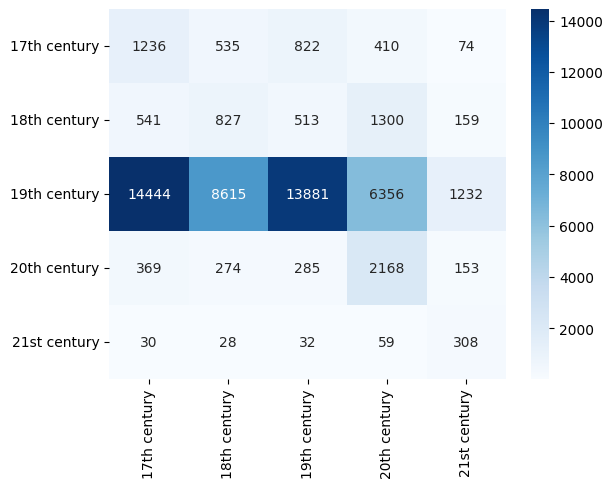

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline


random_forest_pipe = make_pipeline(CountVectorizer(), RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=True, random_state=RANDOM_SEED))
random_forest_pipe.fit([open(os.path.join(train_path, file_name), 'r').read() for file_name in X_train], y_train)

random_forest_pipe.score([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid], y_valid)

print("="*30, "Valid (Partial)", "="*30)
evaluate_model(random_forest_pipe, X_valid, y_valid, valid_path)

random_forest_y_pred = random_forest_pipe.predict([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid])
print_confusion_matrix( y_valid, random_forest_y_pred)

print("="*30, "Valid (Full)", "="*30)
evaluate_model(random_forest_pipe, X_valid_full, y_valid_full, valid_path)

random_forest_y_pred_full = random_forest_pipe.predict([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid_full])
print_confusion_matrix( y_valid_full, random_forest_y_pred_full)

### XGBoost

============================== Valid (Partial) ==============================
              precision    recall  f1-score   support

           0       0.48      0.46      0.47       457
           1       0.45      0.40      0.42       457
           2       0.44      0.43      0.44       457
           3       0.56      0.70      0.62       457
           4       0.92      0.82      0.87       457

    accuracy                           0.56      2285
   macro avg       0.57      0.56      0.56      2285
weighted avg       0.57      0.56      0.56      2285



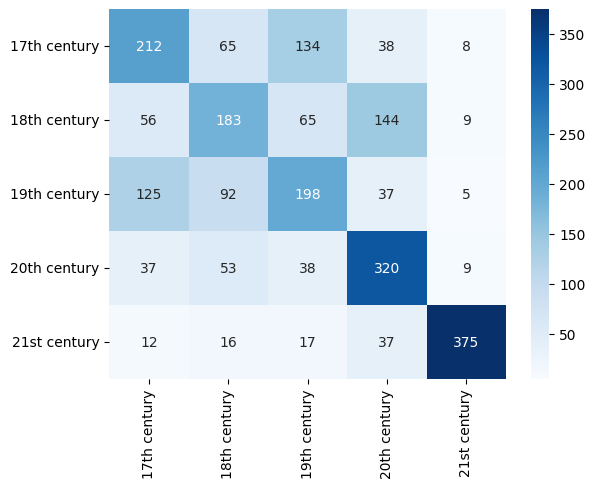

============================== Valid (Full) ==============================
              precision    recall  f1-score   support

           0       0.09      0.43      0.15      3077
           1       0.12      0.40      0.19      3340
           2       0.91      0.40      0.55     44528
           3       0.29      0.71      0.41      3249
           4       0.23      0.82      0.36       457

    accuracy                           0.42     54651
   macro avg       0.33      0.55      0.33     54651
weighted avg       0.77      0.42      0.50     54651



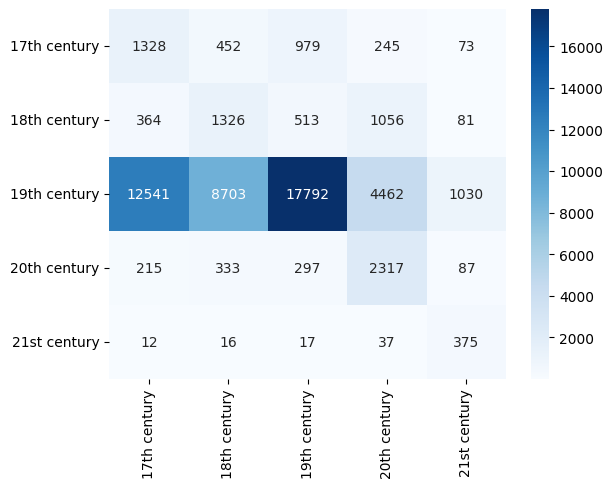

In [30]:
import xgboost as xgb

xgboost_pipe = make_pipeline(CountVectorizer(), xgb.XGBClassifier(n_jobs=-1, n_estimators=100, max_depth=5, random_state=RANDOM_SEED))
xgboost_pipe.fit([open(os.path.join(train_path, file_name), 'r').read() for file_name in X_train], y_train)

xgboost_pipe.score([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid], y_valid)

print("="*30, "Valid (Partial)", "="*30)
evaluate_model(xgboost_pipe, X_valid, y_valid, valid_path)
xgboost_y_pred = xgboost_pipe.predict([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid])
print_confusion_matrix(y_valid, xgboost_y_pred)

print("="*30, "Valid (Full)", "="*30)
evaluate_model(xgboost_pipe, X_valid_full, y_valid_full, valid_path)
xgboost_y_pred_full = xgboost_pipe.predict([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid_full])
print_confusion_matrix(y_valid_full, xgboost_y_pred_full)

In [31]:
y_pred_rf = random_forest_pipe.predict([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid])
y_pred_rf_full = random_forest_pipe.predict([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid_full])
y_pred_xgboost = xgboost_pipe.predict([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid])
y_pred_xgboost_full = xgboost_pipe.predict([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid_full])
print("Random Forest:", mean_avg_error(y_valid, y_pred_rf))
print("Random Forest (Full):", mean_avg_error(y_valid_full, y_pred_rf_full))
print("XGBoost:", mean_avg_error(y_valid, y_pred_xgboost))
print("XGBoost (Full):", mean_avg_error(y_valid_full, y_pred_xgboost_full))

[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 out of 100 | elapsed:    0.0s remaining:    1.8s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 out of 100 | elapsed:    0.2s remaining:    8.5s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:    0.2s finished


Random Forest: 0.9518599562363238
Random Forest (Full): 1.035278402956945
XGBoost: 0.7592997811816192
XGBoost (Full): 0.8936341512506633


### BERT

In [45]:
import torch
from transformers import BertTokenizer, BertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-cased")
model = BertModel.from_pretrained("google-bert/bert-base-cased")

In [27]:
def bert_confusion(model, dataloader):
    model.eval()
    y_pred = []
    y_true = []
    for text, labels in dataloader:
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
        labels = torch.tensor(labels).to(device)
        output = model(**tokens)
        y_pred.extend(output.squeeze().argmax(dim=1).detach().cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    print("BERT:", mean_avg_error(np.array(y_true), np.array(y_pred)))
    print_confusion_matrix(y_true, y_pred)

In [27]:
# from torch.utils.data import DataLoader, Dataset

# class TextDataset(Dataset):
#     def __init__(self, file_names, path):
#         self.file_names = file_names
#         self.path = path

#     def __len__(self):
#         return len(self.file_names)

#     def __getitem__(self, idx):
#         file_name = self.file_names[idx]
#         with open(os.path.join(self.path, file_name), 'r') as file:
#             text = file.read()
#         return text

# batch_size = 32
# model.eval()
# dataset = TextDataset(X_valid, valid_path)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# # embeddings = []
# # for batch in tqdm(dataloader):
# #     tokens = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
# #     output = model(**tokens)
# #     embeddings.extend(output.last_hidden_state.mean(dim=1).detach().numpy())

In [28]:
# # plot the embeddings in 2D using PCA
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# pca = PCA(n_components=2)
# embeddings_2d = pca.fit_transform(torch.cat([torch.tensor(e).unsqueeze(0) for e in embeddings]).numpy())

# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_valid)
# plt.colorbar()
# plt.show()

In [28]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset

model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10, # was 3
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    seed=RANDOM_SEED,
)

class TextDataset(Dataset):
    def __init__(self, file_names, labels, path):
        self.file_names = file_names
        self.labels = labels
        self.path = path

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        with open(os.path.join(self.path, file_name), 'r') as file:
            text = file.read()
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt")
        tokens = {key: val.squeeze(0) for key, val in tokens.items()}
        tokens['label'] = self.labels[idx]
        return tokens
    
train_dataset = TextDataset(X_train, y_train, train_path)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

trainer.train()

# save the model
trainer.save_model('./models/bert-finetuned')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


ModuleNotFoundError: No module named 'wandb.sdk'

In [35]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# load checkpoint
model = BertForSequenceClassification.from_pretrained('./models/bert-finetuned')
model.eval()

# measure the mean absolute error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
batch_size = 32
y_pred = []
for i in tqdm(range(0, len(X_valid), batch_size)):
    batch = X_valid[i:i+batch_size]
    tokens = tokenizer([open(os.path.join(valid_path, file_name), 'r').read() for file_name in batch], padding='max_length', truncation=True, return_tensors="pt")
    tokens = {key: val.squeeze(0).to(device) for key, val in tokens.items()}
    output = model(**tokens)
    y_pred.extend(output.logits.argmax(dim=1).detach().cpu().numpy())

print("BERT:", mean_avg_error(np.array(y_valid), np.array(y_pred)))

y_pred_full = []
for i in tqdm(range(0, len(X_valid_full), batch_size)):
    batch = X_valid_full[i:i+batch_size]
    tokens = tokenizer([open(os.path.join(valid_path, file_name), 'r').read() for file_name in batch], padding='max_length', truncation=True, return_tensors="pt")
    tokens = {key: val.squeeze(0).to(device) for key, val in tokens.items()}
    output = model(**tokens)
    y_pred_full.extend(output.logits.argmax(dim=1).detach().cpu().numpy())

print("BERT (Full):", mean_avg_error(np.array(y_valid_full), np.array(y_pred_full)))

100%|██████████| 72/72 [00:39<00:00,  1.82it/s]


BERT: 0.562363238512035


100%|██████████| 1708/1708 [15:46<00:00,  1.80it/s]

BERT (Full): 0.7188889498819784


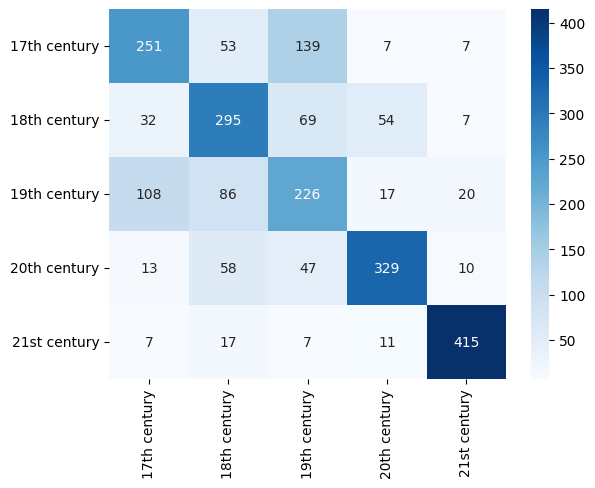

In [36]:
print_confusion_matrix(y_valid, y_pred)

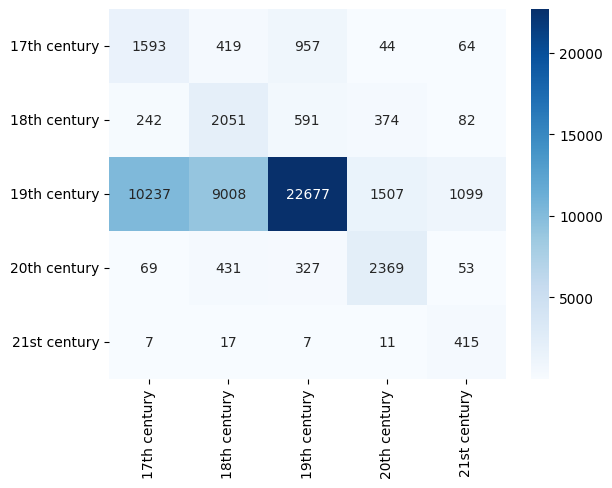

In [37]:
print_confusion_matrix(y_valid_full, y_pred_full)

In [38]:
# keep just words in wordnet
from nltk.corpus import wordnet as wn
import re

def is_word_in_wordnet(word):
    return len(wn.synsets(word)) > 0

def filter_words(text):
    # It also remove the stopwords?
    # remove non alphanumeric characters
    text = ''.join([char if char.isalnum() else ' ' for char in text])
    # remove multiple spaces
    text = re.sub('\s+', ' ', text)
    
    return ' '.join([word for word in text.split() if is_word_in_wordnet(word)])

In [39]:
text_example = open(os.path.join(train_path, train_files[0]), 'r').read()

print(text_example)
print(filter_words(text_example))

the business of bee-hunters; and who, from the very nature of their calling, are often brought into contact with the bears as well as the bees. Under the direction of the Dyak, our hunters made an excursion to a range of wooded hills, not far from Sambos, where the sun-bear was known to exist in great numbers; and where one was likely to be found almost at any time. As they were passing through the woods, they observed a very singular species of tree--indeed many species, that might be styled singular; but one pre-eminently so, that strongly arrested their attention. These trees did not grow in any great numbers together; but only two or three in one place; and more generally they stood singly--apart from any of their own kind, and surrounded by other trees of the forest. But though surrounded by other sorts, they were overtopped by none. On the contrary, their own tops rose above all the others to a vast height; and, what was most singular, they did not put forth a branch from their t

In [40]:
chars = set()
for file_name in tqdm(X_train):
    with open(os.path.join(train_path, file_name), 'r') as file:
        text = file.read()
        for char in text:
            chars.add(char)

100%|██████████| 9170/9170 [00:03<00:00, 2860.55it/s]


In [41]:
filtered_X_train2 = []
for file_name in tqdm(X_train):
    with open(os.path.join(train_path, file_name), 'r') as file:
        text = file.read()
        text = ''.join([ char for char in text if ord(char) <= 127 or ord(char) in [172, 187, 180, 163]])
        filtered_X_train2.append(text)

100%|██████████| 9170/9170 [00:02<00:00, 3355.51it/s]


In [42]:
chars_ord = {}
for c in chars:
    chars_ord[c] = ord(c)

chars_ord = {k: v for k, v in sorted(chars_ord.items(), key=lambda item: item[1])}

chars_ord

{' ': 32,
 '!': 33,
 '"': 34,
 '#': 35,
 '$': 36,
 '%': 37,
 '&': 38,
 "'": 39,
 '(': 40,
 ')': 41,
 '*': 42,
 '+': 43,
 ',': 44,
 '-': 45,
 '.': 46,
 '/': 47,
 '0': 48,
 '1': 49,
 '2': 50,
 '3': 51,
 '4': 52,
 '5': 53,
 '6': 54,
 '7': 55,
 '8': 56,
 '9': 57,
 ':': 58,
 ';': 59,
 '<': 60,
 '=': 61,
 '>': 62,
 '?': 63,
 '@': 64,
 'A': 65,
 'B': 66,
 'C': 67,
 'D': 68,
 'E': 69,
 'F': 70,
 'G': 71,
 'H': 72,
 'I': 73,
 'J': 74,
 'K': 75,
 'L': 76,
 'M': 77,
 'N': 78,
 'O': 79,
 'P': 80,
 'Q': 81,
 'R': 82,
 'S': 83,
 'T': 84,
 'U': 85,
 'V': 86,
 'W': 87,
 'X': 88,
 'Y': 89,
 'Z': 90,
 '[': 91,
 '\\': 92,
 ']': 93,
 '^': 94,
 '_': 95,
 '`': 96,
 'a': 97,
 'b': 98,
 'c': 99,
 'd': 100,
 'e': 101,
 'f': 102,
 'g': 103,
 'h': 104,
 'i': 105,
 'j': 106,
 'k': 107,
 'l': 108,
 'm': 109,
 'n': 110,
 'o': 111,
 'p': 112,
 'q': 113,
 'r': 114,
 's': 115,
 't': 116,
 'u': 117,
 'v': 118,
 'w': 119,
 'x': 120,
 'y': 121,
 'z': 122,
 '{': 123,
 '|': 124,
 '}': 125,
 '~': 126,
 '\x80': 128,
 '\x82':

============================== Valid (Partial) ==============================
              precision    recall  f1-score   support

           0       0.48      0.46      0.47       457
           1       0.45      0.40      0.42       457
           2       0.44      0.43      0.44       457
           3       0.56      0.70      0.62       457
           4       0.92      0.82      0.87       457

    accuracy                           0.56      2285
   macro avg       0.57      0.56      0.56      2285
weighted avg       0.57      0.56      0.56      2285



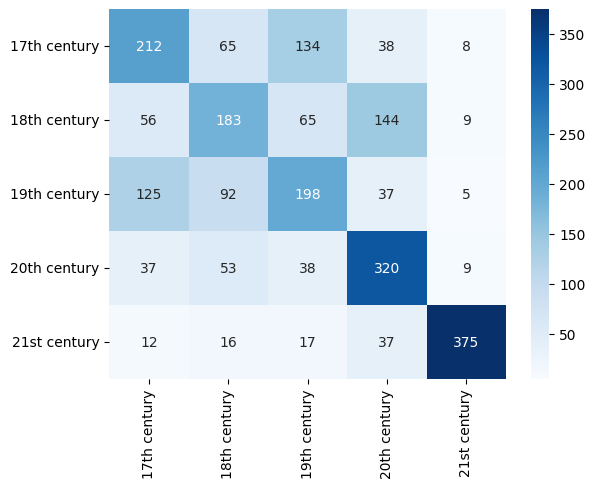

============================== Valid (Full) ==============================
              precision    recall  f1-score   support

           0       0.09      0.43      0.15      3077
           1       0.12      0.40      0.19      3340
           2       0.91      0.40      0.55     44528
           3       0.29      0.71      0.41      3249
           4       0.23      0.82      0.36       457

    accuracy                           0.42     54651
   macro avg       0.33      0.55      0.33     54651
weighted avg       0.77      0.42      0.50     54651



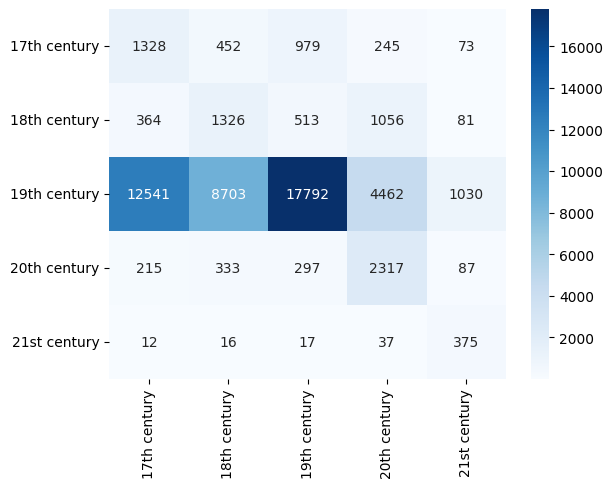

In [43]:
import xgboost as xgb

xgboost_pipe = make_pipeline(CountVectorizer(), xgb.XGBClassifier(n_jobs=-1, n_estimators=100, max_depth=5, random_state=RANDOM_SEED))
xgboost_pipe.fit([open(os.path.join(train_path, file_name), 'r').read() for file_name in X_train], y_train)

xgboost_pipe.score([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid], y_valid)

print("="*30, "Valid (Partial)", "="*30)
evaluate_model(xgboost_pipe, X_valid, y_valid, valid_path)
xgboost_y_pred = xgboost_pipe.predict([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid])
print_confusion_matrix(y_valid, xgboost_y_pred)

print("="*30, "Valid (Full)", "="*30)
evaluate_model(xgboost_pipe, X_valid_full, y_valid_full, valid_path)
xgboost_y_pred_full = xgboost_pipe.predict([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid_full])
print_confusion_matrix(y_valid_full, xgboost_y_pred_full)

In [44]:
filtered_X_train = []

for file_name in tqdm(X_train):
    with open(os.path.join(train_path, file_name), 'r') as file:
        filtered_X_train.append(filter_words(file.read()))

filtered_X_valid = []

for file_name in tqdm(X_valid):
    with open(os.path.join(valid_path, file_name), 'r') as file:
        filtered_X_valid.append(filter_words(file.read()))


filtered_X_valid_full = []

for file_name in tqdm(X_valid_full):
    with open(os.path.join(valid_path, file_name), 'r') as file:
        filtered_X_valid_full.append(filter_words(file.read()))


100%|██████████| 54651/54651 [07:40<00:00, 118.79it/s]


              precision    recall  f1-score   support

           0       0.45      0.40      0.42       457
           1       0.40      0.37      0.38       457
           2       0.38      0.37      0.37       457
           3       0.52      0.65      0.58       457
           4       0.79      0.75      0.77       457

    accuracy                           0.51      2285
   macro avg       0.51      0.51      0.50      2285
weighted avg       0.51      0.51      0.50      2285



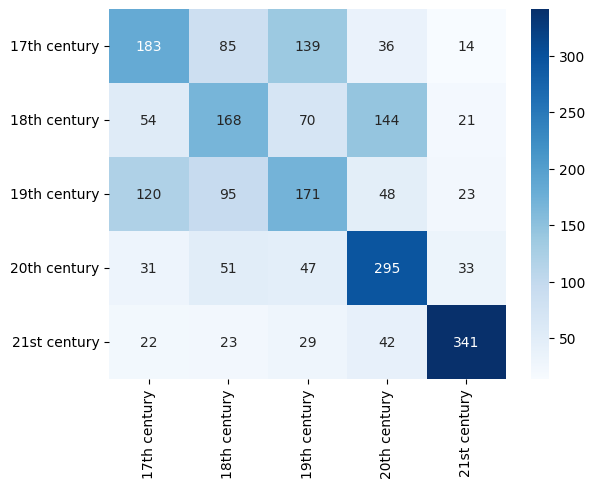

In [45]:
import xgboost as xgb

xgboost_pipe = make_pipeline(CountVectorizer(), xgb.XGBClassifier(n_jobs=-1, n_estimators=100, max_depth=5, random_state=RANDOM_SEED))
xgboost_pipe.fit(filtered_X_train, y_train)

xgboost_pipe.score([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid], y_valid)

evaluate_model(xgboost_pipe, X_valid, y_valid, valid_path)
xgboost_y_pred = xgboost_pipe.predict([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid])
print_confusion_matrix(y_valid, xgboost_y_pred)

============================== Valid (Partial) ==============================
              precision    recall  f1-score   support

           0       0.49      0.42      0.45       457
           1       0.45      0.41      0.43       457
           2       0.42      0.45      0.43       457
           3       0.58      0.72      0.64       457
           4       0.88      0.82      0.85       457

    accuracy                           0.56      2285
   macro avg       0.56      0.56      0.56      2285
weighted avg       0.56      0.56      0.56      2285



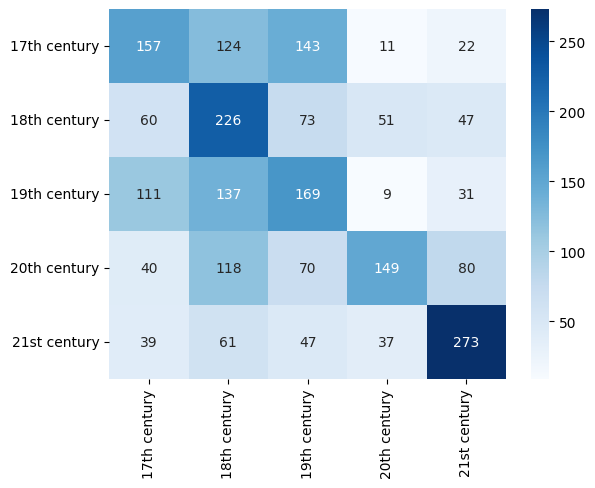

============================== Valid (Full) ==============================
              precision    recall  f1-score   support

           0       0.09      0.40      0.15      3077
           1       0.12      0.41      0.19      3340
           2       0.91      0.42      0.57     44528
           3       0.29      0.70      0.41      3249
           4       0.20      0.82      0.32       457

    accuracy                           0.43     54651
   macro avg       0.32      0.55      0.33     54651
weighted avg       0.77      0.43      0.51     54651



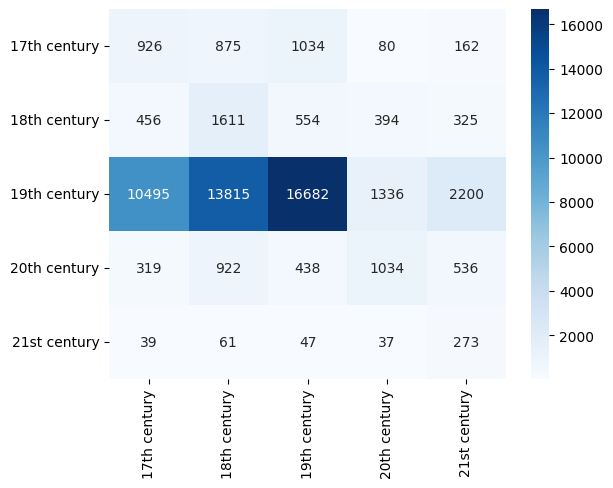

XGBoost: 1.012253829321663
XGBoost (Full): 0.9403304605588186


In [46]:
import xgboost as xgb

xgboost_pipe = make_pipeline(CountVectorizer(), xgb.XGBClassifier(n_jobs=-1, n_estimators=100, max_depth=5, random_state=RANDOM_SEED))
xgboost_pipe.fit(filtered_X_train2, y_train)

xgboost_pipe.score([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid], y_valid)

print("="*30, "Valid (Partial)", "="*30)
evaluate_model(xgboost_pipe, X_valid, y_valid, valid_path)
xgboost_y_pred = xgboost_pipe.predict(filtered_X_valid)
print_confusion_matrix(y_valid, xgboost_y_pred)

print("="*30, "Valid (Full)", "="*30)
evaluate_model(xgboost_pipe, X_valid_full, y_valid_full, valid_path)
xgboost_y_pred_full = xgboost_pipe.predict(filtered_X_valid_full)
print_confusion_matrix(y_valid_full, xgboost_y_pred_full)


print("XGBoost:", mean_avg_error(y_valid, xgboost_y_pred))
print("XGBoost (Full):", mean_avg_error(y_valid_full, xgboost_y_pred_full))

In [47]:
from torch.utils.data import DataLoader, Dataset

def preprocess_data(document):
    stop_words = stopwords.words('english')
 
    texts = [word for word in simple_preprocess(str(document)) if word not in stop_words]
    
    return ' '.join(texts)

class TextDataset(Dataset):
    def __init__(self, file_names, labels, path, preprocess=False):
        self.file_names = file_names
        self.labels = labels
        self.path = path
        self.preprocess = preprocess

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        with open(os.path.join(self.path, file_name), 'r') as file:
            text = file.read()
            if self.preprocess:
                text = preprocess_data(text)
        return text, self.labels[idx]

In [33]:
# add a classification head to bert
import torch
import torch.nn as nn
import torch.optim as optim

class BertForSequenceClassification(nn.Module):
    def __init__(self, bert, num_classes):
        super(BertForSequenceClassification, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)

    def forward(self, input_ids, token_type_ids, attention_mask):
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

In [49]:
train_dataset = TextDataset(X_train, y_train, train_path)
valid_dataset = TextDataset(X_valid, y_valid, valid_path)
valid_full_dataset = TextDataset(X_valid_full, y_valid_full, valid_path)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
valid_full_dataloader = DataLoader(valid_full_dataset, batch_size=batch_size, shuffle=False)

/tmp/ipykernel_1189868/1247523555.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch: 0 Loss: 1.1153334379196167


/tmp/ipykernel_1189868/2600907141.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


BERT: 1.052516411378556


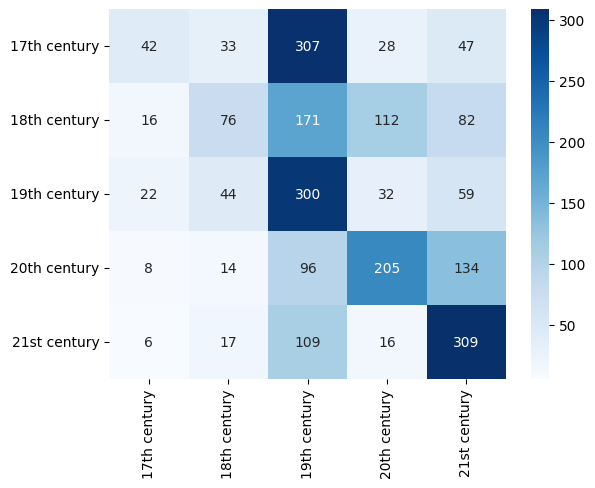

/tmp/ipykernel_1189868/1247523555.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch: 1 Loss: 0.8007572889328003


/tmp/ipykernel_1189868/2600907141.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


BERT: 0.9085339168490153


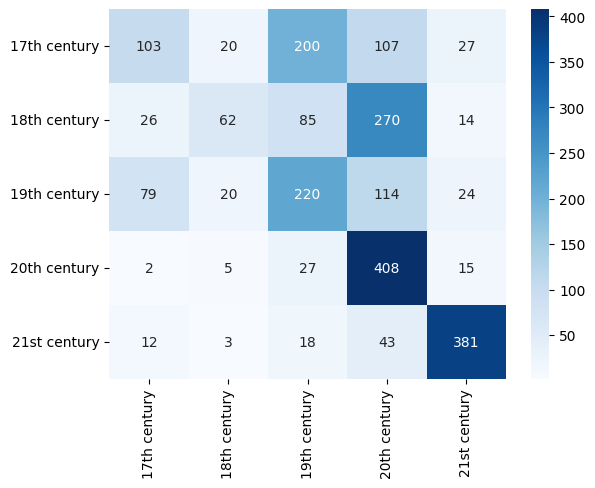

/tmp/ipykernel_1189868/1247523555.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch: 2 Loss: 0.6733200550079346


/tmp/ipykernel_1189868/2600907141.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


BERT: 0.72472647702407


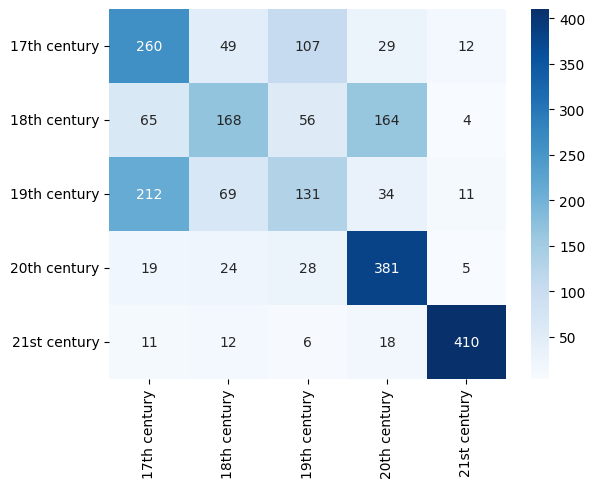

/tmp/ipykernel_1189868/1247523555.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch: 3 Loss: 1.1495308876037598


/tmp/ipykernel_1189868/2600907141.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


BERT: 0.6350109409190372


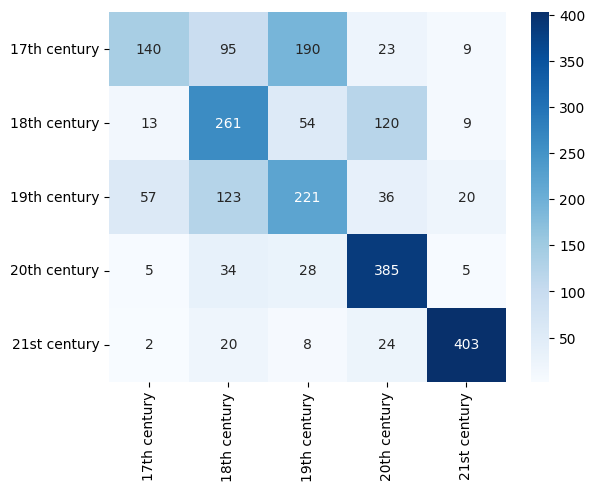

/tmp/ipykernel_1189868/1247523555.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch: 4 Loss: 0.014369219541549683


/tmp/ipykernel_1189868/2600907141.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


BERT: 0.661706783369803


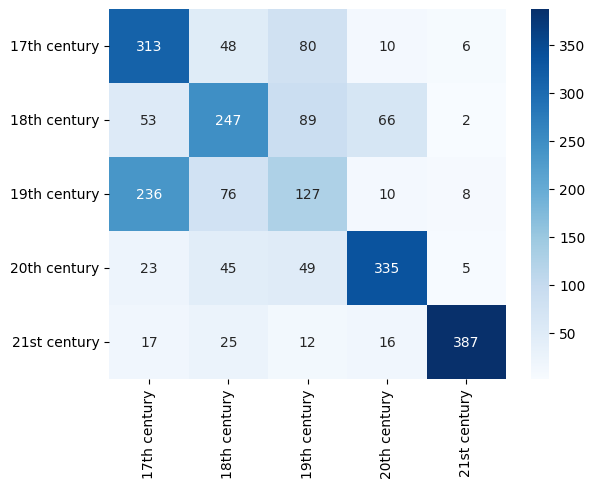

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-cased")
model = BertModel.from_pretrained("google-bert/bert-base-cased")

# for param in model.parameters():
#     param.requires_grad = False
    
model_classifier = BertForSequenceClassification(model, 5)
model_classifier.to(device)

optimizer = optim.Adam(model_classifier.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# assert False

for epoch in range(5):
    model_classifier.train()
    for text, labels in train_dataloader:
        optimizer.zero_grad()
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
        labels = torch.tensor(labels).to(device)
        output = model_classifier(**tokens)
        #loss = criterion(output, labels)
        loss = criterion(output.view(-1, 5), labels.view(-1))
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch, "Loss:", loss.item())
    bert_confusion(model_classifier, valid_dataloader)


BERT: 0.661706783369803


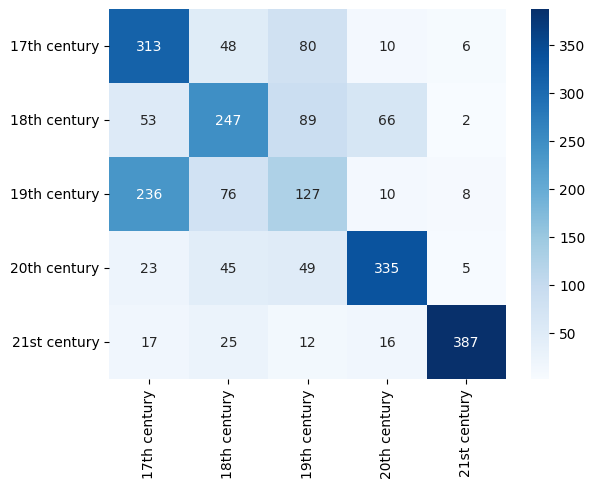

In [51]:
model_classifier.to(device)
model_classifier.eval()
y_pred = []
for text, labels in valid_dataloader:
    tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
    output = model_classifier(**tokens)
    y_pred.extend(output.squeeze().argmax(dim=1).detach().cpu().numpy())

print("BERT:", mean_avg_error(np.array(y_valid), np.array(y_pred)))

print_confusion_matrix(y_valid, y_pred)

### Modern BERT

MAE: 1.4

In [ ]:
# from transformers import BertForSequenceClassification, Trainer, TrainingArguments
# from torch.utils.data import DataLoader, Dataset

# model = BertForSequenceClassification.from_pretrained("answerdotai/ModernBERT-large", num_labels=5)
# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=3,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=64,
#     warmup_steps=500,
#     weight_decay=0.01,
#     logging_dir='./logs',
#     seed=RANDOM_SEED,
# )

# class TextDataset(Dataset):
#     def __init__(self, file_names, labels, path):
#         self.file_names = file_names
#         self.labels = labels
#         self.path = path

#     def __len__(self):
#         return len(self.file_names)

#     def __getitem__(self, idx):
#         file_name = self.file_names[idx]
#         with open(os.path.join(self.path, file_name), 'r') as file:
#             text = file.read()
#         tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt")
#         tokens = {key: val.squeeze(0) for key, val in tokens.items()}
#         tokens['label'] = self.labels[idx]
#         return tokens
    
# train_dataset = TextDataset(X_train, y_train, train_path)
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
# )

# trainer.train()

# # save the model
# trainer.save_model('./models/modernbert-finetuned')

You are using a model of type modernbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight',

Step,Training Loss
500,1.649300
1000,1.636600
1500,1.626700
2000,1.620800
2500,1.617600
3000,1.617100
3500,1.616200
4000,1.614400
4500,1.613100
5000,1.612300


In [ ]:
# from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# # load checkpoint
# model = BertForSequenceClassification.from_pretrained('./models/modernbert-finetuned')
# model.eval()

# # measure the mean absolute error
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# model.to(device)
# batch_size = 16
# y_pred = []
# for i in tqdm(range(0, len(X_valid), batch_size)):
#     batch = X_valid[i:i+batch_size]
#     tokens = tokenizer([open(os.path.join(valid_path, file_name), 'r').read() for file_name in batch], padding='max_length', truncation=True, return_tensors="pt")
#     tokens = {key: val.squeeze(0).to(device) for key, val in tokens.items()}
#     output = model(**tokens)
#     y_pred.extend(output.logits.argmax(dim=1).detach().cpu().numpy())

# print("BERT:", mean_avg_error(np.array(y_valid), np.array(y_pred)))

  0%|          | 0/143 [00:00<?, ?it/s]100%|██████████| 143/143 [09:37<00:00,  4.04s/it]

BERT: 1.4


### Sentence transformer

In [44]:
import pickle
from sentence_transformers import SentenceTransformer

with open('./embeddings/gte-Qwen2-7B-instruct/train.pkl', 'rb') as file:
    train_embeddings = pickle.load(file)

with open('./embeddings/gte-Qwen2-7B-instruct/valid.pkl', 'rb') as file:
    valid_embeddings = pickle.load(file)

with open('./embeddings/gte-Qwen2-7B-instruct/valid_full.pkl', 'rb') as file:
    valid_full_embeddings = pickle.load(file)

In [37]:
from sentence_transformers import SentenceTransformer
import torch
sent_model = SentenceTransformer("Alibaba-NLP/gte-Qwen2-7B-instruct", trust_remote_code=True)
sent_model.max_seq_length = 500

similarities = sent_model.similarity(torch.tensor(list(train_embeddings.values())), torch.tensor(list(valid_embeddings.values())))

Loading checkpoint shards: 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]
/tmp/ipykernel_1572134/56510274.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  similarities = sent_model.similarity(torch.tensor(list(train_embeddings.values())), torch.tensor(list(valid_embeddings.values())))


In [66]:
len(valid_full_embeddings), len(X_valid_full)

(54651, 55796)

In [85]:
aa = dict(zip(X_valid, y_valid))
bb = dict(zip(X_train, y_train))

In [84]:
list(train_embeddings.items())[0][0]

'train_text14772.txt'

In [88]:
bb['train_text11327.txt']

0

1.9566360052562417


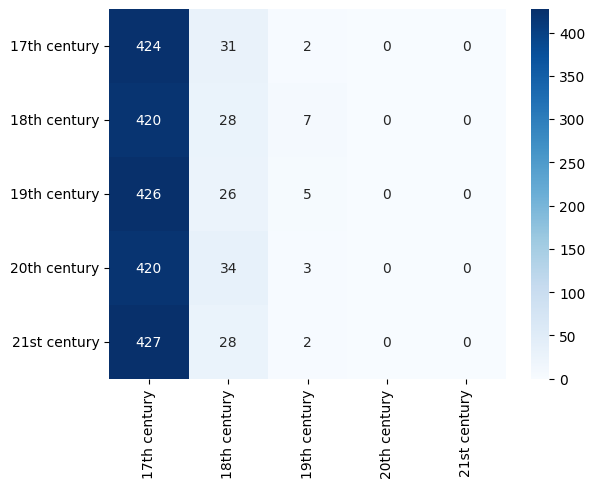

In [94]:
gts = []
prds = []
for idx, (name, emb) in enumerate(valid_embeddings.items()):
    gt = aa[name]
    s_id = similarities[idx].argmax()
    pred = bb[list(train_embeddings.items())[s_id][0]]
    gts.append(gt)
    prds.append(pred)

gts = np.array(gts)
prds = np.array(prds)
print(mean_avg_error(gts, prds))
print_confusion_matrix(gts, prds)

In [42]:
indices = similarities.argmax(axis=1)
sent_pred = np.array(y_train)[[indices]].flatten()

print(mean_avg_error(y_valid, sent_pred))

ValueError: operands could not be broadcast together with shapes (2285,) (9141,) 

Loading checkpoint shards: 100%|██████████| 7/7 [00:01<00:00,  5.40it/s]


Computing train embeddings


Batches: 100%|██████████| 287/287 [58:14<00:00, 12.17s/it]


Computing valid embeddings


Batches: 100%|██████████| 72/72 [14:31<00:00, 12.10s/it]


============================== Valid (Partial) ==============================
0.5190371991247265


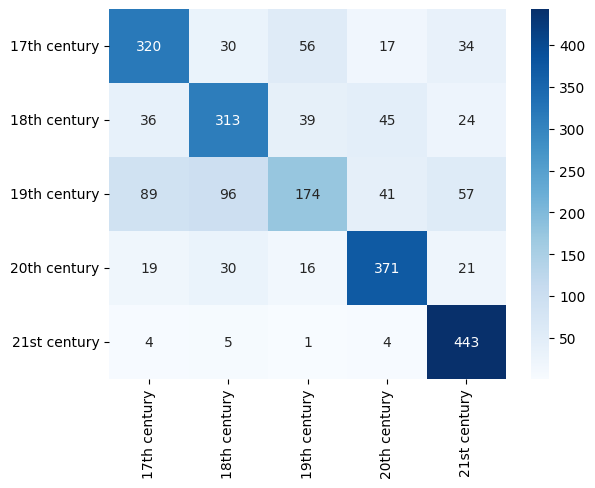

Batches:   1%|          | 16/1744 [03:15<5:52:15, 12.23s/it]


KeyboardInterrupt: 

In [22]:
from sentence_transformers import SentenceTransformer

sent_model = SentenceTransformer("Alibaba-NLP/gte-Qwen2-7B-instruct", trust_remote_code=True)
sent_model.max_seq_length = 500
# sent_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

print("Computing train embeddings")
embeddings = sent_model.encode([open(os.path.join(train_path, file_name), 'r').read() for file_name in X_train], show_progress_bar=True)

print("Computing valid embeddings")
valid_emb = sent_model.encode([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid], show_progress_bar=True)


print("="*30, "Valid (Partial)", "="*30)
similarities = sent_model.similarity(valid_emb, embeddings)
indices = similarities.argmax(axis=1)
sent_pred = np.array(y_train)[[indices]].flatten()

print(mean_avg_error(y_valid, sent_pred))
print_confusion_matrix(y_valid, sent_pred)

valid_full_emb = sent_model.encode([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid_full], show_progress_bar=True)

print("="*30, "Valid (Full)", "="*30)
similarities = sent_model.similarity(valid_full_emb, embeddings)
indices = similarities.argmax(axis=1)
sent_pred = np.array(y_train)[[indices]].flatten()

print(mean_avg_error(y_valid_full, sent_pred))
print_confusion_matrix(y_valid_full, sent_pred)

In [ ]:
# # Load model directly
# from transformers import AutoTokenizer, AutoModel

# sent_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
# sent_model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# from transformers import AutoTokenizer, AutoModel
# import torch
# import torch.nn.functional as F

# #Mean Pooling - Take attention mask into account for correct averaging
# def mean_pooling(model_output, attention_mask):
#     token_embeddings = model_output[0] #First element of model_output contains all token embeddings
#     input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#     return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# # Tokenize sentences
# encoded_input = sent_tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# # Compute token embeddings
# with torch.no_grad():
#     model_output = sent_model(**encoded_input)

# # Perform pooling
# sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# # Normalize embeddings
# sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

# print("Sentence embeddings:")
# print(sentence_embeddings)


### Canine

In [ ]:
from transformers import CanineTokenizer, CanineModel

model = CanineModel.from_pretrained('google/canine-c')
tokenizer = CanineTokenizer.from_pretrained('google/canine-c')

inputs = ["Life is like a box of chocolates.", "You never know what you gonna get."]
encoding = tokenizer(inputs, padding="longest", truncation=True, return_tensors="pt")

outputs = model(**encoding) # forward pass
pooled_output = outputs.pooler_output
sequence_output = outputs.last_hidden_state


### Topic Modeling

In [21]:
X_train_txt = [open(os.path.join(train_path, file_name), 'r').read() for file_name in X_train]
X_valid_txt = [open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid]

In [25]:
def preprocess_data(documents):
    stop_words = stopwords.words('english')
 
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in documents]
    
    return texts

In [26]:
processed_texts = preprocess_data(X_train_txt)

In [30]:
id2word = corpora.Dictionary(processed_texts)

In [31]:
corpus = [id2word.doc2bow(text) for text in processed_texts]

In [32]:
num_topics = 5
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=RANDOM_SEED, passes=10, alpha='auto', per_word_topics=True)

In [34]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3033425355306362


In [ ]:
# choerence_values = []
# for num_topics in range(1,21):
#     lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=RANDOM_SEED, passes=10, alpha='auto', per_word_topics=True)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     print('Coherence Score:', num_topics, coherence_lda)
#     choerence_values.append((num_topics, coherence_lda))

Coherence Score: 1 0.2820577160482046
Coherence Score: 2 0.29116290936900896
Coherence Score: 3 0.29108274159793834
Coherence Score: 4 0.28286919802837596
Coherence Score: 5 0.3033425355306362
Coherence Score: 6 0.2969462879445508
Coherence Score: 7 0.3139102983744304
Coherence Score: 8 0.34236096744435407
Coherence Score: 9 0.3575983287446462
Coherence Score: 10 0.3412283426538749
Coherence Score: 11 0.4218419552856938
Coherence Score: 12 0.439879075163731
Coherence Score: 13 0.4550600165836394
Coherence Score: 14 0.4306496726762733
Coherence Score: 15 0.43865450600302835
Coherence Score: 16 0.44014900454670336
Coherence Score: 17 0.44148669505477384
Coherence Score: 18 0.44873649946224414
Coherence Score: 19 0.4226592293778942
Coherence Score: 20 0.4374424028878412


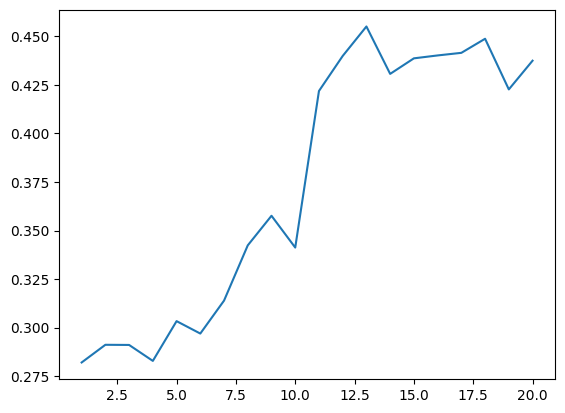

In [ ]:
# plt.plot([x[0] for x in choerence_values[:20]], [x[1] for x in choerence_values[:20]])
# plt.show()

In [47]:
import torch

In [61]:
valid_dataset = TextDataset(X_valid, y_valid, valid_path, preprocess=True)

/tmp/ipykernel_696430/1140720912.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch: 0 Loss: 1.0832710266113281


/tmp/ipykernel_696430/2600907141.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


BERT: 1.3032822757111597


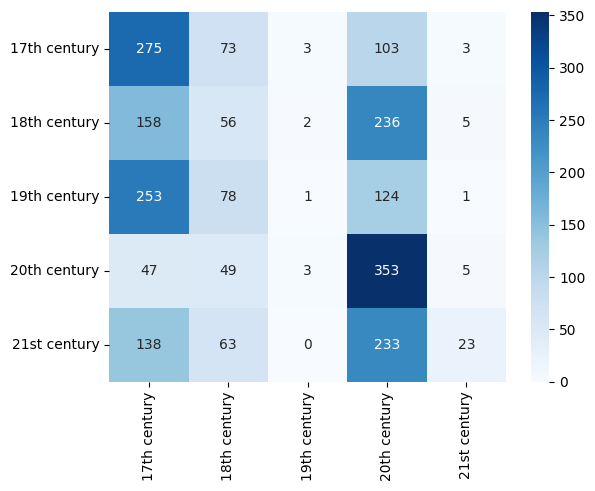

/tmp/ipykernel_696430/1140720912.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch: 1 Loss: 0.978533923625946


/tmp/ipykernel_696430/2600907141.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


BERT: 1.074398249452954


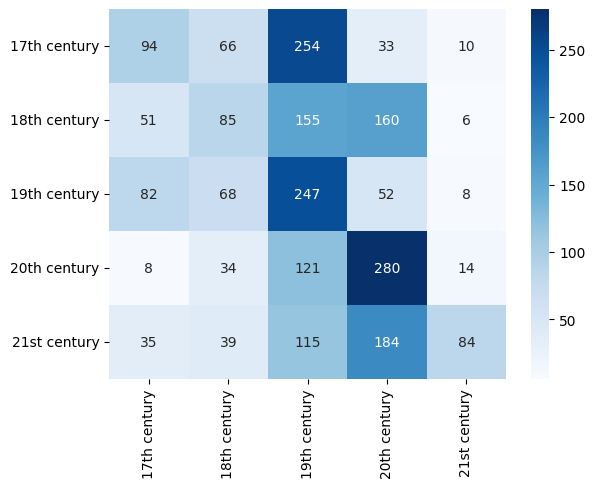

/tmp/ipykernel_696430/1140720912.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch: 2 Loss: 1.0169696807861328


/tmp/ipykernel_696430/2600907141.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


BERT: 1.1024070021881838


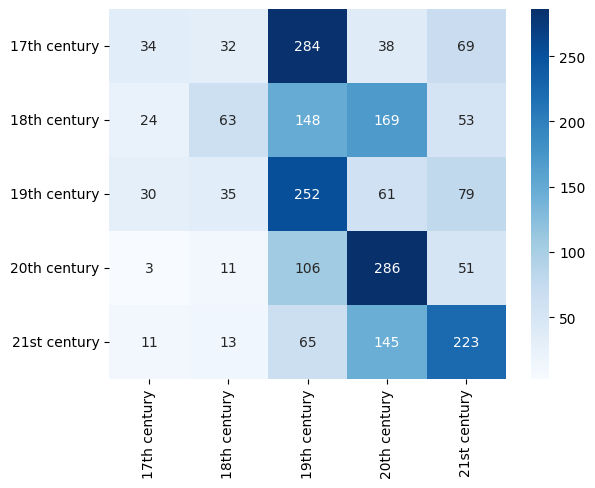

/tmp/ipykernel_696430/1140720912.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch: 3 Loss: 0.4924297630786896


/tmp/ipykernel_696430/2600907141.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


BERT: 1.0665207877461707


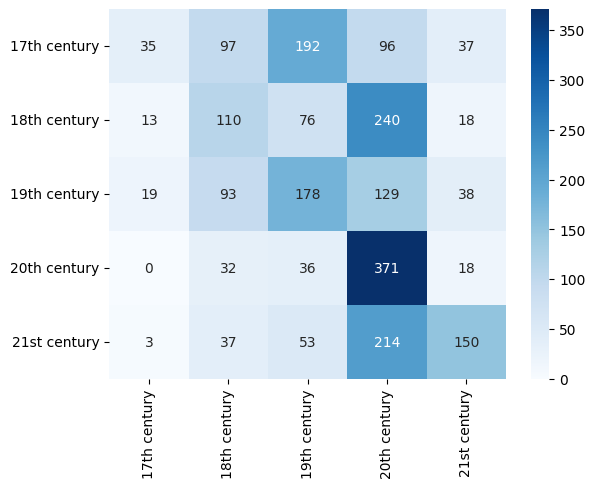

/tmp/ipykernel_696430/1140720912.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch: 4 Loss: 0.1990896314382553


/tmp/ipykernel_696430/2600907141.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


BERT: 1.1404814004376367


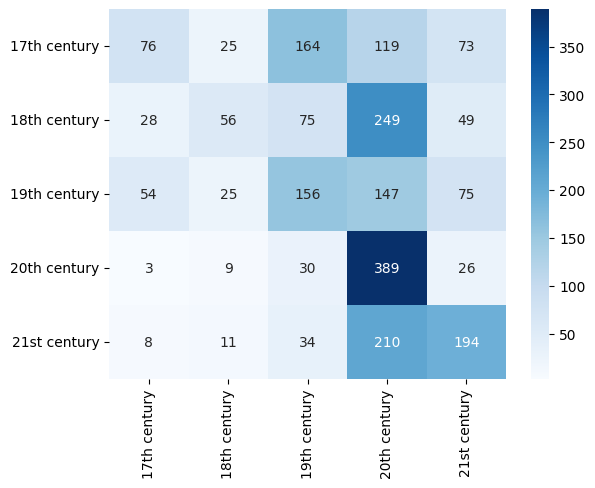

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = TextDataset(X_train, y_train, train_path, preprocess=True)
valid_dataset = TextDataset(X_valid, y_valid, valid_path)


tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-cased")
model = BertModel.from_pretrained("google-bert/bert-base-cased")

# for param in model.parameters():
#     param.requires_grad = False
    
model_classifier = BertForSequenceClassification(model, 5)
model_classifier.to(device)

optimizer = optim.Adam(model_classifier.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(5):
    model_classifier.train()
    for text, labels in train_dataloader:
        optimizer.zero_grad()
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
        labels = torch.tensor(labels).to(device)
        output = model_classifier(**tokens)
        #loss = criterion(output, labels)
        loss = criterion(output.view(-1, 5), labels.view(-1))
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch, "Loss:", loss.item())
    bert_confusion(model_classifier, valid_dataloader)


BERT: 1.1404814004376367


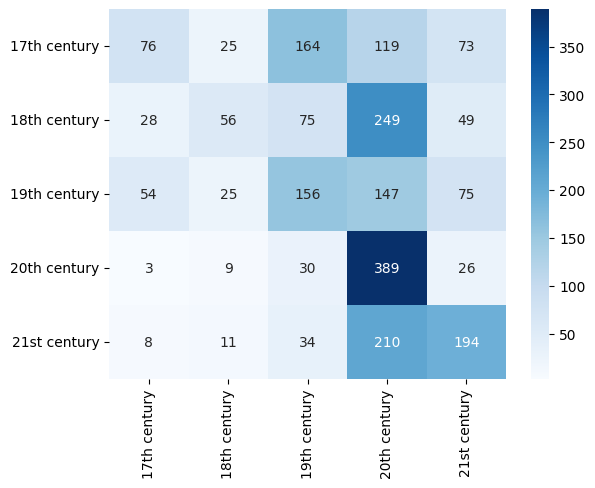

In [62]:
model_classifier.to(device)
model_classifier.eval()
y_pred = []
for text, labels in valid_dataloader:
    tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
    output = model_classifier(**tokens)
    y_pred.extend(output.squeeze().argmax(dim=1).detach().cpu().numpy())

print("BERT:", mean_avg_error(np.array(y_valid), np.array(y_pred)))

print_confusion_matrix(y_valid, y_pred)

In [31]:
class RobertaForSequenceClassification(nn.Module):
    def __init__(self, bert, num_classes):
        super(RobertaForSequenceClassification, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

/tmp/ipykernel_2168336/3435695620.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch: 0 Loss: 1.0778203010559082


/tmp/ipykernel_2168336/2600907141.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


BERT: 1.1024070021881838


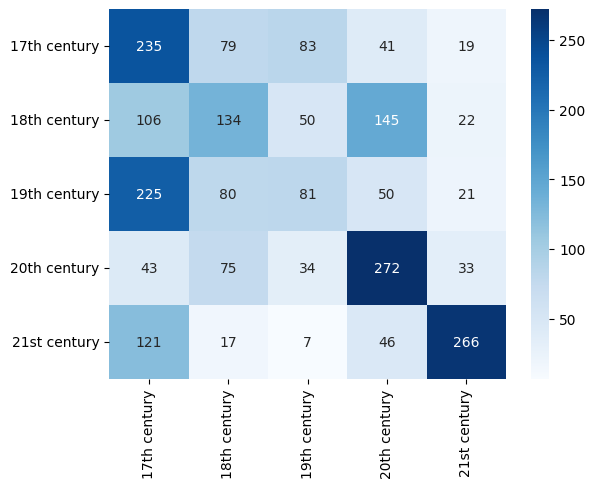

/tmp/ipykernel_2168336/3435695620.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch: 1 Loss: 1.2978646755218506


/tmp/ipykernel_2168336/2600907141.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


BERT: 0.8691466083150985


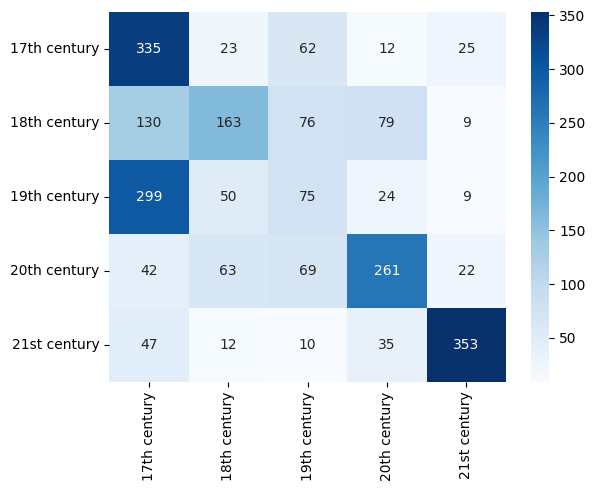

/tmp/ipykernel_2168336/3435695620.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch: 2 Loss: 0.9636581540107727


/tmp/ipykernel_2168336/2600907141.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


BERT: 0.7479212253829322


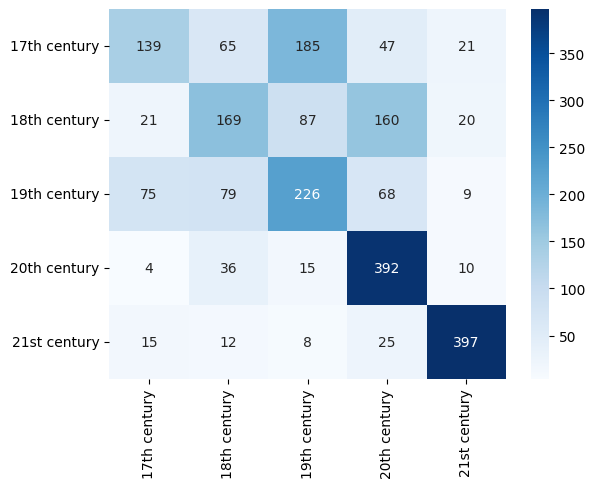

/tmp/ipykernel_2168336/3435695620.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch: 3 Loss: 0.45469364523887634


/tmp/ipykernel_2168336/2600907141.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


BERT: 0.6735229759299781


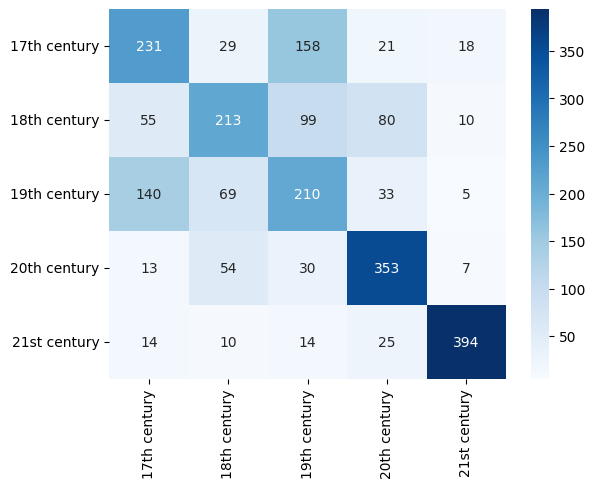

/tmp/ipykernel_2168336/3435695620.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch: 4 Loss: 0.7967216372489929


/tmp/ipykernel_2168336/2600907141.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


BERT: 0.6201312910284464


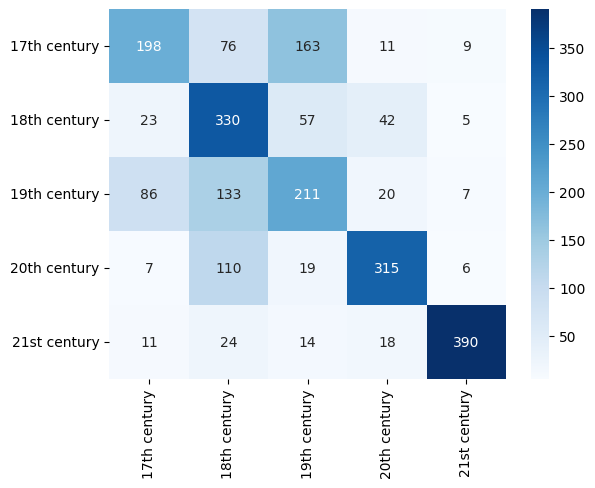

In [32]:
from transformers import XLMRobertaTokenizer, XLMRobertaModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = TextDataset(X_train, y_train, train_path)
valid_dataset = TextDataset(X_valid, y_valid, valid_path)


tokenizer = XLMRobertaTokenizer.from_pretrained("FacebookAI/xlm-roberta-large")
model = XLMRobertaModel.from_pretrained("FacebookAI/xlm-roberta-large")

# for param in model.parameters():
#     param.requires_grad = False
    
model_classifier = RobertaForSequenceClassification(model, 5)
model_classifier.to(device)

optimizer = optim.Adam(model_classifier.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(5):
    model_classifier.train()
    for text, labels in train_dataloader:
        optimizer.zero_grad()
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
        labels = torch.tensor(labels).to(device)
        output = model_classifier(**tokens)
        #loss = criterion(output, labels)
        loss = criterion(output.view(-1, 5), labels.view(-1))
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch, "Loss:", loss.item())
    bert_confusion(model_classifier, valid_dataloader)


### CORAL

In [22]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-cased")
model = BertModel.from_pretrained("google-bert/bert-base-cased")

In [23]:
from torch.utils.data import DataLoader, Dataset

def preprocess_data(document):
    stop_words = stopwords.words('english')
 
    texts = [word for word in simple_preprocess(str(document)) if word not in stop_words]
    
    return ' '.join(texts)

class TextDataset(Dataset):
    def __init__(self, file_names, labels, path, preprocess=False):
        self.file_names = file_names
        self.labels = labels
        self.path = path
        self.preprocess = preprocess

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        with open(os.path.join(self.path, file_name), 'r') as file:
            text = file.read()
            if self.preprocess:
                text = preprocess_data(text)

        levels = [1] * self.labels[idx] + [0] * (5-1 - self.labels[idx]) # NUM_CLASSES = 5
        levels = torch.tensor(levels, dtype=torch.float32)
        return text, self.labels[idx], levels

In [24]:
# add a classification head to bert
import torch
import torch.nn as nn
import torch.optim as optim

class CoralBertForSequenceClassification(nn.Module):
    def __init__(self, bert, num_classes):
        super(CoralBertForSequenceClassification, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.num_classes = num_classes
        # self.classifier = nn.Linear(bert.config.hidden_size, num_classes)
        self.fc = nn.Linear(bert.config.hidden_size, 1, bias=False)
        self.linear_1_bias = nn.Parameter(torch.zeros(num_classes-1).float())

    def forward(self, input_ids, token_type_ids, attention_mask):
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)

        logits = self.fc(pooled_output)
        logits = logits + self.linear_1_bias
        probas = torch.sigmoid(logits)
        return logits, probas

In [82]:
from torch.nn import functional as F
def coral_loss(logits, levels, imp):
    # print(logits.shape, levels.shape, imp.shape)
    # print(logits.device, levels.device, imp.device)
    return (-torch.sum((F.logsigmoid(logits) * levels + (F.logsigmoid(logits) - logits) * (1 - levels))*imp, dim=1)).mean()

In [26]:
train_dataset = TextDataset(X_train, y_train, train_path)
valid_dataset = TextDataset(X_valid, y_valid, valid_path)
valid_full_dataset = TextDataset(X_valid_full, y_valid_full, valid_path)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
valid_full_dataloader = DataLoader(valid_full_dataset, batch_size=batch_size, shuffle=False)

In [39]:
def task_importance_weights(label_array):
    uniq = torch.unique(label_array)
    num_examples = label_array.size(0)

    m = torch.zeros(uniq.shape[0])

    for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq))):
        m_k = torch.max(torch.tensor([label_array[label_array > t].size(0), 
                                      num_examples - label_array[label_array > t].size(0)]))
        m[i] = torch.sqrt(m_k.float())

    imp = m/torch.max(m)
    return imp

In [51]:
from torch.nn import DataParallel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-cased")
model = BertModel.from_pretrained("google-bert/bert-base-cased")

# for param in model.parameters():
#     param.requires_grad = False
    
model_classifier = CoralBertForSequenceClassification(model, 5)
model_classifier.to(device)

optimizer = optim.Adam(model_classifier.parameters(), lr=5e-5)
# criterion = nn.CrossEntropyLoss()

imp = torch.tensor(task_importance_weights(torch.tensor(train_dataloader.dataset.labels))[0:4], dtype=torch.float)
imp = imp.to(device)

for epoch in range(10):
    model_classifier.train()
    for text, labels, levels in tqdm(train_dataloader):
        optimizer.zero_grad()
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
        labels = torch.tensor(labels).to(device)
        logits, probas = model_classifier(**tokens)
        levels = torch.tensor(levels).to(device)
        # imp = torch.ones(4, dtype=torch.float).to('cuda')
        cost = coral_loss(logits, levels, imp)
        # loss = criterion(output.view(-1, 5), labels.view(-1)) # loss = criterion(output, labels)
        # loss.backward()
        cost.backward()
        optimizer.step()
    print("Epoch:", epoch, "Loss:", cost.item())
# bert_confusion(model_classifier, valid_dataloader)


/tmp/ipykernel_3888893/3891642083.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imp = torch.tensor(task_importance_weights(torch.tensor(train_dataloader.dataset.labels))[0:4], dtype=torch.float)
  0%|          | 0/574 [00:00<?, ?it/s]/tmp/ipykernel_3888893/3891642083.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
/tmp/ipykernel_3888893/3891642083.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  levels = torch.tensor(levels).to(device)
100%|██████████| 574/574 [03:01<00:00,  3.16it/

Epoch: 0 Loss: 2.090702772140503


100%|██████████| 574/574 [03:01<00:00,  3.15it/s]


Epoch: 1 Loss: 1.6538552045822144


100%|██████████| 574/574 [03:02<00:00,  3.15it/s]


Epoch: 2 Loss: 2.240981340408325


100%|██████████| 574/574 [03:01<00:00,  3.16it/s]


Epoch: 3 Loss: 2.0988502502441406


100%|██████████| 574/574 [03:02<00:00,  3.15it/s]


Epoch: 4 Loss: 0.07647199928760529


100%|██████████| 574/574 [03:02<00:00,  3.15it/s]


Epoch: 5 Loss: 2.2170538902282715


100%|██████████| 574/574 [03:01<00:00,  3.16it/s]


Epoch: 6 Loss: 2.001859664916992


100%|██████████| 574/574 [03:02<00:00,  3.15it/s]


Epoch: 7 Loss: 1.0036685466766357


100%|██████████| 574/574 [03:01<00:00,  3.16it/s]


Epoch: 8 Loss: 1.0808231830596924


100%|██████████| 574/574 [03:01<00:00,  3.16it/s]

Epoch: 9 Loss: 0.0412512943148613


  0%|          | 0/143 [00:00<?, ?it/s]/tmp/ipykernel_3888893/2561980709.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
100%|██████████| 143/143 [00:40<00:00,  3.55it/s]

BERT: 1.0341356673960613


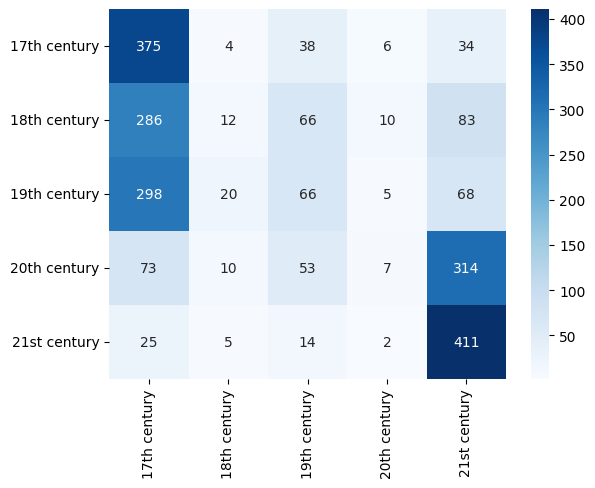

In [83]:
model_classifier.eval()
y_pred = []
y_true = []
for text, labels, levels in tqdm(valid_dataloader):
    tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
    labels = torch.tensor(labels).to(device)
    levels.to(device)
    logits, probas = model_classifier(**tokens)
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    y_pred.extend(predicted_labels.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

print("BERT:", mean_avg_error(np.array(y_true), np.array(y_pred)))
print_confusion_matrix(y_true, y_pred)

## Task 2.2

Since we are dealing with uncertainity, maybe model the bins as gaussian centered on that bin?

In [38]:
from torch.utils.data import DataLoader, Dataset

def preprocess_data(document):
    stop_words = stopwords.words('english')
 
    texts = [word for word in simple_preprocess(str(document)) if word not in stop_words]
    
    return ' '.join(texts)

class TextDataset(Dataset):
    def __init__(self, file_names, labels, path, preprocess=False):
        self.file_names = file_names
        self.labels = labels
        self.path = path
        self.preprocess = preprocess

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        with open(os.path.join(self.path, file_name), 'r') as file:
            text = file.read()
            if self.preprocess:
                text = preprocess_data(text)
        return text, self.labels[idx]

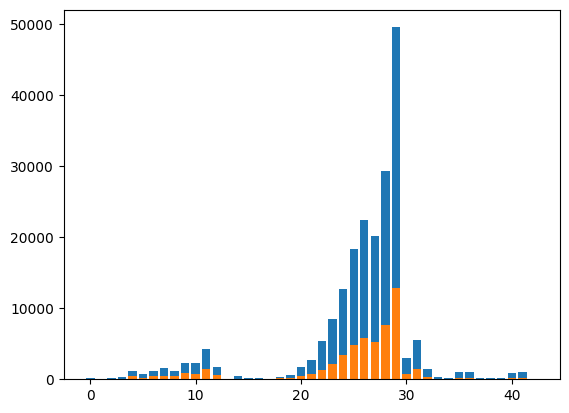

In [39]:
from collections import Counter

np.random.seed(RANDOM_SEED)

X_train_22 = []
y_train_22 = []

X_valid_22 = []
y_valid_22 = []

for idx, row in train.iterrows():
    file_name = row.file_name
    century = row.century
    decade = row.decade
    # year = (century+16)*100 + (decade-1)*10
    year = (century-1) * 10 + (decade-1)
    X_train_22.append(file_name)
    y_train_22.append(year)

for idx, row in valid.iterrows():
    file_name = row.file_name
    century = row.century
    decade = row.decade
    year = (century-1) * 10 + (decade-1)
    y_valid_22.append(year)
    X_valid_22.append(file_name)

train_years_counter = Counter(y_train_22)
valid_years_counter = Counter(y_valid_22)

import matplotlib.pyplot as plt

plt.bar(train_years_counter.keys(), train_years_counter.values())
plt.bar(valid_years_counter.keys(), valid_years_counter.values())
plt.show()

/tmp/ipykernel_45574/3995601186.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(loc='upper right')


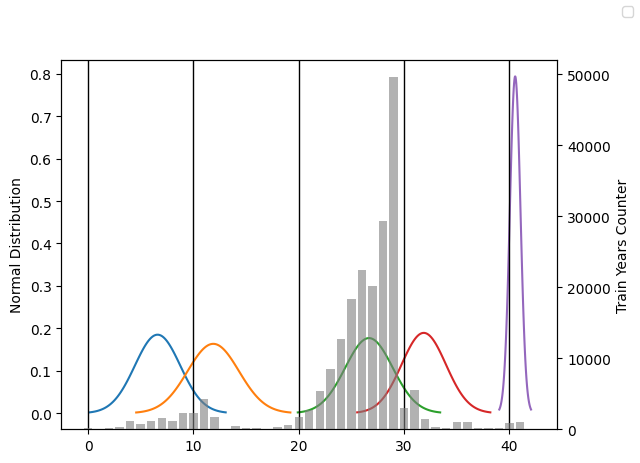

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

cent_dict = {c: [] for c in range(5)}
for x in y_valid_22:
    cent_dict[x // 10].append(x)

fig, ax1 = plt.subplots()

# Plot the normal distributions on the first y-axis
for c in range(5):
    mu = np.mean(cent_dict[c])
    sigma = np.std(cent_dict[c])
    median = np.median(cent_dict[c])
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma))
    # print a vertical line at the median
    # ax1.axvline(median, color='brown', linestyle='dashed', linewidth=1)
ax1.set_ylabel('Normal Distribution')

for x in range(0, 50, 10):
    ax1.axvline(x, color='black', linestyle='solid', linewidth=1)

# Create a second y-axis to plot the bar chart
ax2 = ax1.twinx()
ax2.bar(train_years_counter.keys(), train_years_counter.values(), alpha=0.6, color='gray')
ax2.set_ylabel('Train Years Counter')

# Add legends and show the plot
fig.legend(loc='upper right')
plt.show()

In [41]:
min(y_train_22), max(y_train_22)

(0, 42)

### BERT

In [42]:
# add a classification head to bert
import torch
import torch.nn as nn
import torch.optim as optim

class BertForSequenceClassification(nn.Module):
    def __init__(self, bert, num_classes):
        super(BertForSequenceClassification, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)

    def forward(self, input_ids, token_type_ids, attention_mask):
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

In [43]:
train22_dataset = TextDataset(X_train_22, y_train_22, train_path)
valid22_dataset = TextDataset(X_valid_22, y_valid_22, valid_path) # Full
# valid_full_dataset = TextDataset(X_valid_full, y_valid_full, valid_path)

batch_size = 16
train22_dataloader = DataLoader(train22_dataset, batch_size=batch_size, shuffle=True)
valid22_dataloader = DataLoader(valid22_dataset, batch_size=batch_size, shuffle=False)
# valid_full_dataloader = DataLoader(valid_full_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# from transformers import BertTokenizer, BertModel

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-cased")
# model = BertModel.from_pretrained("google-bert/bert-base-cased")

# # for param in model.parameters():
# #     param.requires_grad = False
    
# model_decade_classifier = BertForSequenceClassification(model, 43)
# model_decade_classifier.to(device)

# optimizer = optim.Adam(model_decade_classifier.parameters(), lr=1e-5)
# criterion = nn.CrossEntropyLoss()

# # assert False

# for epoch in range(5):
#     model_decade_classifier.train()
#     for text, labels in tqdm(train22_dataloader):
#         optimizer.zero_grad()
#         tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
#         labels = torch.tensor(labels).to(device)
#         output = model_decade_classifier(**tokens)
#         #loss = criterion(output, labels)
#         loss = criterion(output.view(-1, 43), labels.view(-1))
#         loss.backward()
#         optimizer.step()
#     print("Epoch:", epoch, "Loss:", loss.item())
#     # bert_confusion(model_decade_classifier, valid_dataloader)
    
# torch.save(model_decade_classifier.state_dict(), 'models/decade_classifier_weights.pt')

  0%|          | 0/12795 [00:00<?, ?it/s]/tmp/ipykernel_2321508/2622420810.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
 29%|██▉       | 3695/12795 [19:25<47:49,  3.17it/s]  


KeyboardInterrupt: 

In [ ]:
# model_decade_classifier = BertForSequenceClassification(model, 43)
# model_decade_classifier.load_state_dict(torch.load('models/decade_classifier_weights.pt'))

<All keys matched successfully>

In [44]:
valid_22_dataset = TextDataset(X_valid_22, y_valid_22, valid_path)

batch_size = 16
valid_22_dataloader = DataLoader(valid_22_dataset, batch_size=batch_size, shuffle=False)

In [45]:
from transformers import BertTokenizer, BertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-cased")
model = BertModel.from_pretrained("google-bert/bert-base-cased")

# for param in model.parameters():
#     param.requires_grad = False
    
model_decade_classifier = BertForSequenceClassification(model, 43)
model_decade_classifier.load_state_dict(torch.load('models/decade_classifier_weights.pt'))
model_decade_classifier.to(device)

model_decade_classifier.eval()

model_decade_classifier.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for text, labels in tqdm(valid_22_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
        output = model_decade_classifier(**tokens)
        predictions = output.argmax(dim=1)
        y_pred.extend(predictions.detach().cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print("BERT:", mean_avg_error(np.array(y_true), np.array(y_pred)))


  1%|██▏                                                                                                                                                                            | 43/3416 [00:14<19:15,  2.92it/s]


KeyboardInterrupt: 

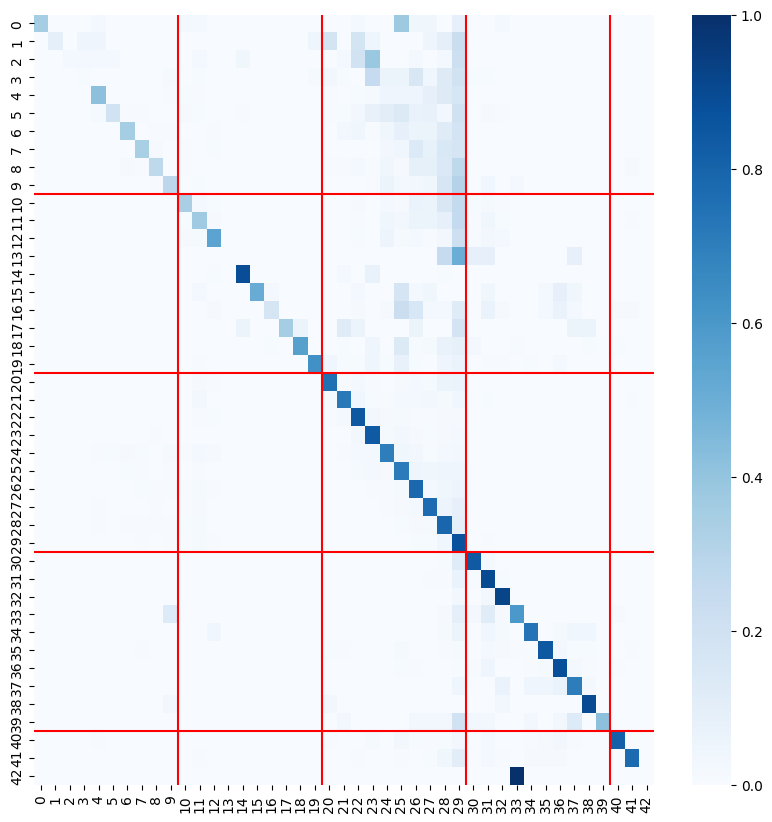

In [53]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap='Blues')
# make rectangles grouping the decades
plt.axvline(10, color='red')
plt.axvline(20, color='red')
plt.axvline(30, color='red')
plt.axvline(40, color='red')
plt.axhline(10, color='red')
plt.axhline(20, color='red')
plt.axhline(30, color='red')
plt.axhline(40, color='red')
plt.show()

In [54]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

final_rank = np.mean(np.abs(y_pred - y_true))

print(f"Final Rank: {final_rank}")

task21 = mean_avg_error(np.array([ yt // 10 for yt in y_true]), np.array([ yp // 10 for yp in y_pred]))
print(f"Task 2.1: {task21}")

Final Rank: 2.4583447695376113
Task 2.1: 0.19770909955901997


In [ ]:
from transformers import BertTokenizer, BertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-cased")
model = BertModel.from_pretrained("google-bert/bert-base-cased")

# for param in model.parameters():
#     param.requires_grad = False
    
model_decade_classifier = BertForSequenceClassification(model, 43)
model_decade_classifier.load_state_dict(torch.load('models/decade_classifier_weights.pt'))
model_decade_classifier.to(device)

model_decade_classifier.eval()

model_decade_classifier.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for text, labels in tqdm(valid_22_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
        output = model_decade_classifier(**tokens)
        predictions = output.argmax(dim=1)
        y_pred.extend(predictions.detach().cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        assert False

print("BERT:", mean_avg_error(np.array(y_true), np.array(y_pred)))
# print_confusion_matrix(y_true, y_pred)


In [32]:
import pickle
# with open('values/model_decade_classifier_y_true.pkl', 'wb') as file:
#     pickle.dump(y_true, file)

# with open('values/model_decade_classifier_y_pred.pkl', 'wb') as file:
#     pickle.dump(y_pred, file)

with open('values/model_decade_classifier_y_true.pkl', 'rb') as file:
    y_true = pickle.load(file)

with open('values/model_decade_classifier_y_pred.pkl', 'rb') as file:
    y_pred = pickle.load(file)

**TODO**
- [ ] Train CORAL on the decades
- [ ] Conformal Prediction

### Confromal Prediction

In [46]:
from sklearn.model_selection import train_test_split
# Split validation data into calibration and test sets
X_calib, X_test, y_calib, y_test = train_test_split(
    X_valid_22, y_valid_22, test_size=0.5, random_state=RANDOM_SEED
)

# Create datasets and dataloaders
calib_dataset = TextDataset(X_calib, y_calib, valid_path)
test_dataset = TextDataset(X_test, y_test, valid_path)
calib_dataloader = DataLoader(calib_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [47]:
%%capture

from transformers import BertTokenizer, BertModel
import numpy as np
from tqdm import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-cased")
model = BertModel.from_pretrained("google-bert/bert-base-cased")
model_decade_classifier = BertForSequenceClassification(model, 43)
model_decade_classifier.load_state_dict(torch.load('models/decade_classifier_weights.pt'))
model_decade_classifier.to(device)
model_decade_classifier.eval()

In [49]:
# Get predictions and softmax probabilities for calibration set
calib_probs = []
calib_preds = []
calib_true = []

with torch.no_grad():
    for text, labels in tqdm(calib_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        calib_probs.extend(probabilities.detach().cpu().numpy())
        calib_preds.extend(predictions.detach().cpu().numpy())
        calib_true.extend(labels.cpu().numpy())

# Compute nonconformity scores: 1 - probability of predicted class
nonconformity_scores = []
for i, prob in enumerate(calib_probs):
    pred = calib_preds[i]
    nonconformity_scores.append(1 - prob[pred])

# Set confidence level (e.g., 90%)
confidence_level = 0.90
alpha = 1 - confidence_level

# Find the threshold for the given confidence level
threshold = np.quantile(nonconformity_scores, 1 - alpha)

# Evaluate on test set with prediction intervals
test_preds = []
test_intervals = []
test_true = []

with torch.no_grad():
    for text, labels in tqdm(test_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        
        # Get prediction intervals
        for i, prob in enumerate(probabilities):
            pred = predictions[i].item()
            
            # Include in prediction set all labels with nonconformity score <= threshold
            prediction_set = []
            for label in range(43):
                if 1 - prob[label].item() <= threshold:
                    prediction_set.append(label)
            
            test_preds.append(pred)
            test_intervals.append(prediction_set)
            test_true.append(labels[i].item())

# Calculate metrics
coverage = sum([true in interval for true, interval in zip(test_true, test_intervals)]) / len(test_true)
avg_interval_size = np.mean([len(interval) for interval in test_intervals])

print(f"BERT MAE: {mean_avg_error(np.array(test_true), np.array(test_preds))}")
print(f"Conformal prediction coverage: {coverage:.4f}")
print(f"Average prediction interval size: {avg_interval_size:.2f} decades")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [09:27<00:00,  3.01it/s]


NameError: name 'mean_avg_error' is not defined

In [52]:
print(f"BERT MAE: {mean_avg_error(np.array(test_true), np.array(test_preds))}")
print(f"Conformal prediction coverage: {coverage:.4f}")
print(f"Average prediction interval size: {avg_interval_size:.2f} decades")

BERT MAE: 2.453121569201493
Conformal prediction coverage: 0.7220
Average prediction interval size: 0.90 decades


In [33]:
# with open('values/cf_model_decade_classifier_test_intervals.pkl', 'wb') as file:
#     pickle.dump(test_intervals, file)

# with open('values/cf_model_decade_classifier_test_true.pkl', 'wb') as file:
#     pickle.dump(test_true, file)

# with open('values/cf_model_decade_classifier_test_preds.pkl', 'wb') as file:
#     pickle.dump(test_preds, file)

with open('values/cf_model_decade_classifier_test_intervals.pkl', 'rb') as file:
    test_intervals = pickle.load(file)

with open('values/cf_model_decade_classifier_test_true.pkl', 'rb') as file:
    test_true = pickle.load(file)

with open('values/cf_model_decade_classifier_test_preds.pkl', 'rb') as file:
    test_preds = pickle.load(file)

In [55]:
len(test_intervals), len(test_true), len(test_preds), len(test_dataset)

(27326, 27326, 27326, 27326)

In [40]:
interval_zero = [ (ti, tp, tt) for ti, tt, tp  in zip(test_intervals, test_true, test_preds) if len(ti) == 0]

zeroes = [ 1 if tp == tt else 0 for ti, tp, tt in interval_zero ]

zero_pred = [ tp for ti, tp, tt in interval_zero]
zero_true = [ tt for ti, tp, tt in interval_zero]

not_zero_pred = [ tp for ti, tp, tt in zip(test_intervals, test_preds, test_true) if len(ti) > 0]
not_zero_true = [ tt for ti, tp, tt in zip(test_intervals, test_preds, test_true) if len(ti) > 0]

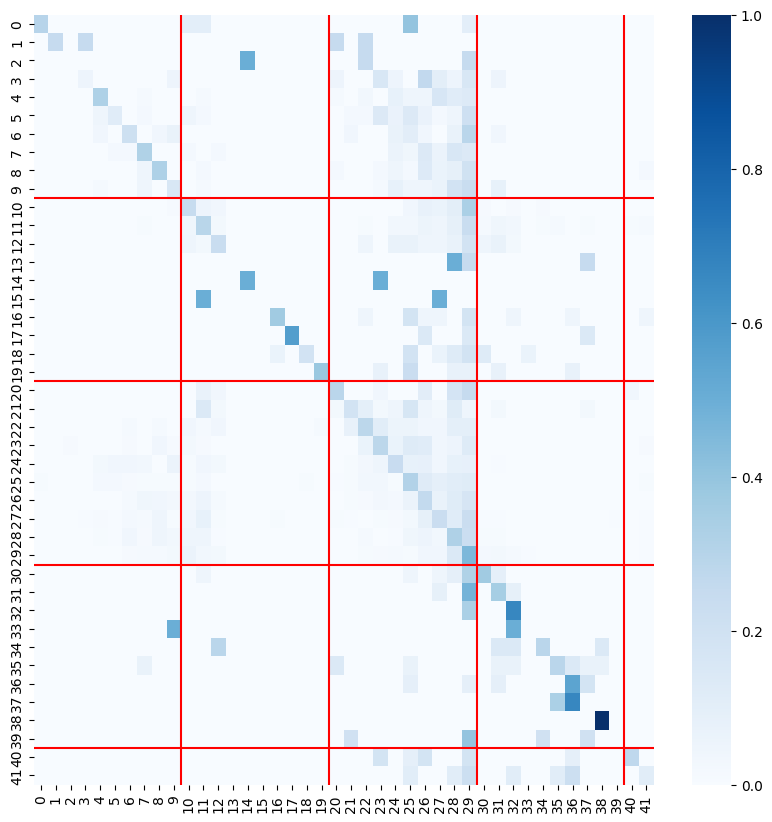

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(zero_true, zero_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap='Blues')
# make rectangles grouping the decades
plt.axvline(10, color='red')
plt.axvline(20, color='red')
plt.axvline(30, color='red')
plt.axvline(40, color='red')
plt.axhline(10, color='red')
plt.axhline(20, color='red')
plt.axhline(30, color='red')
plt.axhline(40, color='red')
plt.show()

In [89]:
zeroes_test = [(zp,td) for z, zp, td in zip(zeroes, zero_pred, test_dataset) if z == 0]

In [104]:
len(test_intervals), len(test_preds), len(test_dataset)

(27326, 27326, 27326)

In [69]:
examples = []
tps = []
tts = []
for ti, tt, tp, td in zip(test_intervals, test_true, test_preds, test_dataset):
    if len(ti) != 0:
        continue
    # if tt == tp:
    #     continue

    # if tt // 10 != tp // 10:
    tt_norm = ((tt // 10) + 16) * 100 + ((tt % 10)) * 10
    tp_notm = ((tp // 10) + 16) * 100 + ((tp % 10)) * 10
    # print(tt, tp, td[0])
    # print((tt,tt_norm), (tp, tp_notm), td[0])
    examples.append((tt, td[0]))
    tps.append(tp)
    tts.append(tt)


# for z_pred, (z_text, z_label) in zeroes_test:
#     z_label_norm = ((z_label // 10) + 16) * 100 + ((z_label % 10)) * 10
#     print(z_label, z_pred, z_label_norm, z_text)

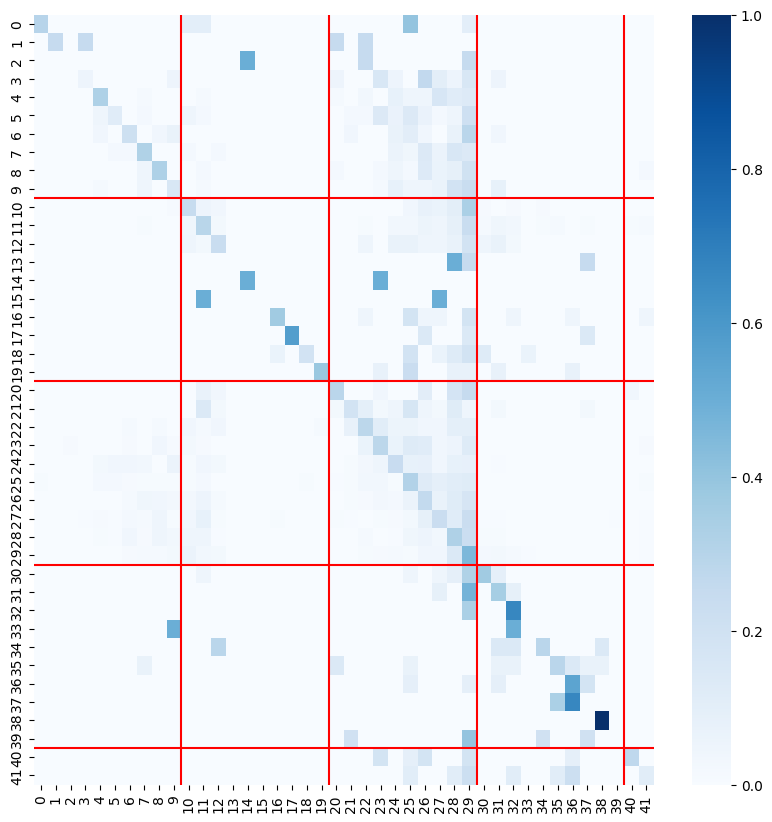

In [70]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(tts, tps)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap='Blues')
# make rectangles grouping the decades
plt.axvline(10, color='red')
plt.axvline(20, color='red')
plt.axvline(30, color='red')
plt.axvline(40, color='red')
plt.axhline(10, color='red')
plt.axhline(20, color='red')
plt.axhline(30, color='red')
plt.axhline(40, color='red')
plt.show()

7 25 of my reader to enroll himself for a short space as a member of Ã¢ÂÂthe establishment,Ã¢ÂÂ or even to sojourn one day beneath a roof where so many originals were congregated; to witness the very table itself, set out with its artificial fruits and flowers, its pine-apples in wax, and its peaches of paper,--all the appliances by which Mrs. D., in her ardent zeal, hoped to propagate refinement and abstemiousness; high-breeding and low diet being, in her esteem, inseparably united. To see the company, the poor old faded and crushed flowers of mock gentility,--widows and unmarried daughters of tax-collectors long Ã¢ÂÂgathered;Ã¢ÂÂ polite storekeepers, and apothecaries to the Ã¢ÂÂForces,Ã¢ÂÂ cultivating the Graces at the cost of their appetites, and descending, in costumes of twenty years back, in the pleasing delusion of being Ã¢ÂÂdressedÃ¢ÂÂ for dinner; while here and there some unhappy skipper, undergoing a course of refinement, looked like a bear in a Ã¢ÂÂballet,Ã¢ÂÂ

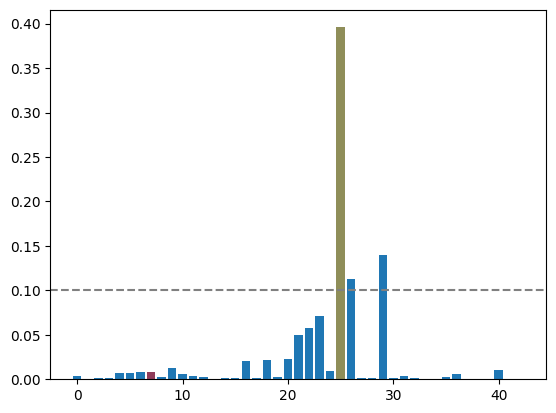

7 26 his forces. He could conceal the injury done him even from his wife, but there was an injury. He was not quite the man that he had been before. From day to day, and from hour to hour, he was always remonstrating with himself because it was so. He was conscious that in some degree he had been cowed, and was ever fighting against the feeling. His tenderness to his wife was perhaps increased, because he knew that she still suffered from the letter; but he was almost ashamed of his own tenderness, as being a sign of weakness. He made himself very busy in these days,--busy among his brother magistrates, busy among his farming operations, busy with his tenants, busy among his books, so as to show to those around him that he was one who could perform all the duties of life, and enjoy all the pleasures, with an open brow and a clear conscience. He had been ever bold and self-asserting; but now he was perhaps a little over-bold. But through it all the Australian letter and the Australian w

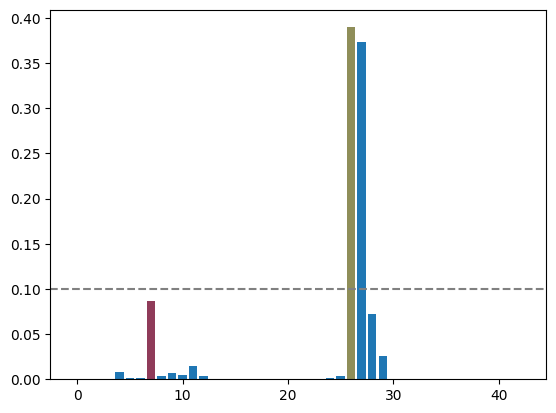

28 10 an honester man!Ã¢ÂÂ Among other distinctions which my wealth forced upon me, were the lavish attentions of match-making mothers. The black spectacles which I always wore, were not repulsive to these diplomatic damesÃ¢ÂÂon the contrary, some of them assured me they were most becoming, so anxious were they to secure me as a son-in-law. Fair girls in their teens, blushing and ingenuous, were artfully introduced to meÃ¢ÂÂor, I _should_ say, thrust forward like slaves in a market for my inspectionÃ¢ÂÂthough, to do them justice, they were remarkably shrewd and sharp-witted for their tender years. Young as they were, they were keenly alive to the importance of making a good matchÃ¢ÂÂand no doubt the pretty innocents laid many dainty schemes in their own minds for liberty and enjoyment when one or the other of them should become the Countess Oliva and fool the old black-spectacled husband to her heartÃ¢ÂÂs content. Needless to say their plans were not destined to be fulfilled

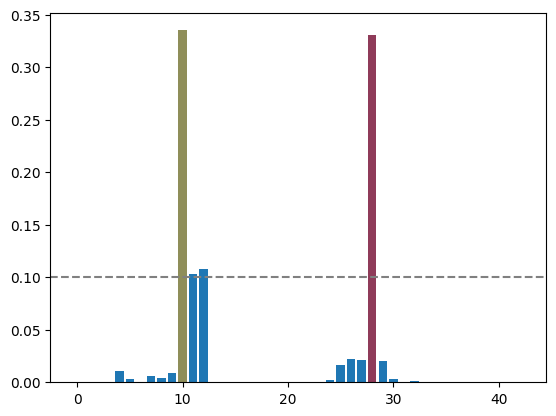

25 25 the English house, Brown and Co., who, with smiling face, has already cashed my drafts for me. He will do it! The very man! Why did I not think of him sooner? Yes; if the letter have not reached him I shall tell him that I expect it every day, and its amount. He will advance the money. "Twelve o'clock gone. There is no time to be lost. He's in his counting-house by this. I shall at once apply to him." I seized my hat, and hastening out of the hotel, took my way through the streets towards the banking-house of Brown and Co. CHAPTER FIFTY TWO. BROWN AND CO. The banking-house of Brown and Co. was in Canal Street. From the Saint Louis Exchange, Canal Street may be approached by the Rue Conti, or the parallel street of the Rue Royale. The latter is the favourite promenade of the gay Creole-French, as Saint Charles Street is for the fashionable Americans. You will wonder at this _melange_ of French and English in the nomenclature of streets. The truth is, that New Orleans has a peculia

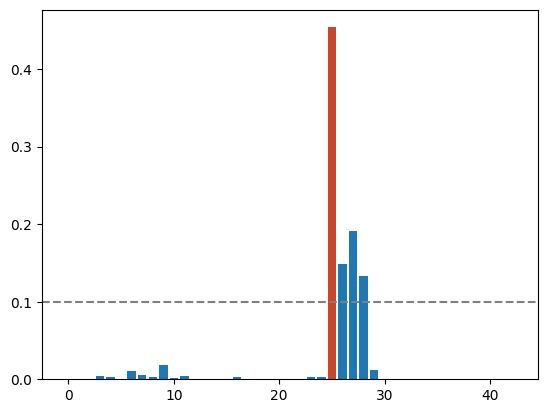

24 23 seclusion and indolence." How often he might have changed his opinion during the course of the ensuing minutes, it is impossible to say, when the brother who conducted him into the apartment again appeared, to inform him that the principal was waiting to receive him. As he was passing through a long corridor, a person hastened by him, whose features a gleam of the evening sun lighted strongly up; but his conductor, taking no notice of the stranger, hurried him on till they reached the door of a chamber at the further end of the passage, knocking at which, a voice desired them to enter; and the brother, making a low reverence, retired. No sooner did the occupant of the room, in which the young noble found himself, perceive him, than, with a bland and cordial manner, he rose from his seat, and advanced to welcome him. He was a man every way worthy of observation: his figure was tall and erect, the height of his appearance increased by the close-fitting, dark robes of his order, alt

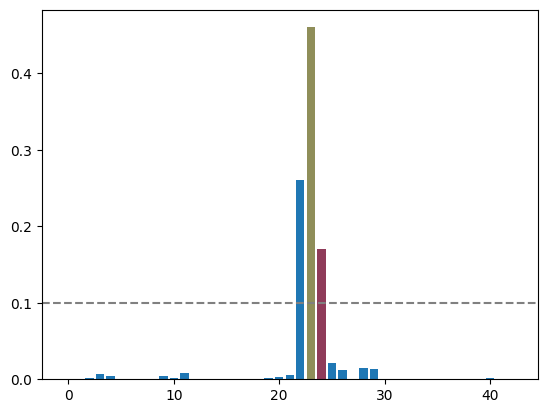

In [79]:
i = 98
for tl, text in examples[i:i+5]:
    tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
    output = model_decade_classifier(**tokens)
    probabilities = torch.softmax(output, dim=1)
    t_hat = output.argmax(dim=1).squeeze().detach().cpu().numpy()
    t_hat_prob = probabilities.squeeze().detach().cpu().numpy()[t_hat]
    tl_prob = probabilities.squeeze().detach().cpu().numpy()[tl]
    print(tl, t_hat, text)
    plt.bar(range(43), probabilities.squeeze().detach().cpu().numpy())
    plt.bar(t_hat, t_hat_prob, color='orange', alpha=0.5)
    # plt.axvline(tl, color='red')
    plt.bar(tl, tl_prob, color='red', alpha=0.5)
    # horiziontal line
    plt.axhline(0.10, color='grey', linestyle='dashed')
    plt.show()